### Note on EUR vs NOK price regression

The OLS regression above uses EUR/MWh prices. Running the same regression with NOK/MWh or NOK/kWh prices would give nearly identical R² values because:

1. EUR/NOK varies slowly (~10.5–11.8 over this period) compared to daily price swings
2. The FX rate is a national constant — it doesn't change the cross-zone price ranking
3. NOK features are ~r>0.99 correlated with EUR features

**For modeling, use EUR/MWh features** (market standard). NOK features are included in the feature matrix for consumer-facing reporting and dashboard displays, not for model training.

# 08 — Statistical Inference Analysis

Deep statistical analysis of Norwegian electricity prices (NO1–NO5), building on
notebooks 05–07. Applies formal statistical tests to quantify relationships between
prices, reservoirs, weather, commodities, and cross-zone dynamics.

**Sections:**
1. Price Distribution Analysis
2. Seasonal Decomposition (STL)
3. Reservoir Deep Dive
4. Export/Import Pattern Analysis
5. Commodity Price Passthrough
6. Zone Decoupling Analysis
7. Autocorrelation & Stationarity
8. Key Findings Summary

In [1]:
# ── Setup & Data Loading ──────────────────────────────────────────────
import sys
from pathlib import Path
import logging

PROJECT_ROOT = str(Path.cwd().parent) if Path("../src").exists() else str(Path.cwd())
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

logging.basicConfig(level=logging.WARNING)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats
from scipy.signal import correlate
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf, grangercausalitytests
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from src.data.fetch_nordpool import fetch_prices
from src.data.fetch_reservoir import fetch_zone_reservoir_with_benchmarks
from src.data.fetch_statnett import fetch_physical_flows, fetch_production_consumption
from src.data.fetch_metro import fetch_zone_weather
from src.data.fetch_commodity import fetch_commodities_daily_filled
from src.data.fetch_fx import fetch_eur_nok_daily_filled

sns.set_style("whitegrid")
plt.rcParams.update({"figure.dpi": 100, "figure.max_open_warning": 30})

ZONES = ["NO_1", "NO_2", "NO_3", "NO_4", "NO_5"]
ZONE_LABELS = {"NO_1": "Oslo", "NO_2": "Kristiansand", "NO_3": "Trondheim",
               "NO_4": "Tromsø", "NO_5": "Bergen"}
ZONE_COLORS = {"NO_1": "tab:blue", "NO_2": "tab:orange", "NO_3": "tab:green",
               "NO_4": "tab:purple", "NO_5": "tab:red"}

START = "2022-01-01"
END   = "2026-01-01"

# EUR/NOK for price conversion — set after FX loads in cell 3
AVG_EUR_NOK = None

def add_nok_axis(ax, eur_nok=None):
    """Add a secondary y-axis showing NOK/kWh alongside EUR/MWh."""
    rate = eur_nok if eur_nok is not None else AVG_EUR_NOK
    if rate is None:
        return None
    ax2 = ax.twinx()
    ymin, ymax = ax.get_ylim()
    ax2.set_ylim(ymin * rate / 1000, ymax * rate / 1000)
    ax2.set_ylabel("NOK/kWh", fontsize=9, color="gray")
    ax2.tick_params(axis="y", labelcolor="gray", labelsize=8)
    return ax2

print(f"Analysis period: {START} → {END}")
print(f"Zones: {', '.join(f'{z} ({ZONE_LABELS[z]})' for z in ZONES)}")

Analysis period: 2022-01-01 → 2026-01-01
Zones: NO_1 (Oslo), NO_2 (Kristiansand), NO_3 (Trondheim), NO_4 (Tromsø), NO_5 (Bergen)


In [2]:
# ── Load all data sources ─────────────────────────────────────────────

# 1) Prices (hourly, all zones)
prices_h = fetch_prices(start_date=START, end_date=END, cache=True)
print(f"Prices: {prices_h.shape[0]:,} hourly rows, columns: {list(prices_h.columns)}")

# Daily mean prices for cross-source joins (strip tz for easier joining)
prices_d = prices_h.resample("D").mean()
if prices_d.index.tz is not None:
    prices_d.index = prices_d.index.tz_localize(None)
prices_d.index.name = "date"
print(f"Prices (daily): {prices_d.shape[0]:,} days")

# 2) Reservoir data per zone (weekly)
reservoir = {}
for z in ZONES:
    try:
        reservoir[z] = fetch_zone_reservoir_with_benchmarks(z, START, END, cache=True)
        print(f"Reservoir {z}: {len(reservoir[z])} weeks")
    except Exception as e:
        print(f"Reservoir {z}: FAILED — {e}")

# 3) Statnett flows & production/consumption (daily)
flows = fetch_physical_flows(from_date=START, cache=True)
prod_cons = fetch_production_consumption(from_date=START, cache=True)
print(f"Statnett flows: {len(flows)} days | Prod/cons: {len(prod_cons)} days")

# 4) Weather per zone (hourly)
weather_h = {}
for z in ZONES:
    try:
        weather_h[z] = fetch_zone_weather(z, START, END, cache=True)
        print(f"Weather {z}: {len(weather_h[z]):,} hourly rows")
    except Exception as e:
        print(f"Weather {z}: FAILED — {e}")

# Daily mean weather
weather_d = {}
for z, df in weather_h.items():
    wd = df.resample("D").agg(
        {"air_temperature": "mean", "wind_speed": "mean", "precipitation": "sum"}
    )
    if wd.index.tz is not None:
        wd.index = wd.index.tz_localize(None)
    weather_d[z] = wd

# 5) Commodities (daily, forward-filled)
commodities = fetch_commodities_daily_filled(start_date=START, end_date=END, cache=True)
if commodities.index.tz is not None:
    commodities.index = commodities.index.tz_localize(None)
print(f"Commodities: {len(commodities)} days, columns: {len(commodities.columns)}")

# 6) FX rates
fx = fetch_eur_nok_daily_filled(start_date=START, end_date=END, cache=True)
if fx.index.tz is not None:
    fx.index = fx.index.tz_localize(None)
print(f"FX: {len(fx)} days")

# Set AVG_EUR_NOK for use in add_nok_axis()
AVG_EUR_NOK = fx["eur_nok"].mean()
print(f"EUR/NOK average: {AVG_EUR_NOK:.2f}")

Prices: 35,088 hourly rows, columns: ['NO_1', 'NO_2', 'NO_3', 'NO_4', 'NO_5']
Prices (daily): 1,462 days
Reservoir NO_1: 209 weeks
Reservoir NO_2: 209 weeks
Reservoir NO_3: 209 weeks
Reservoir NO_4: 209 weeks
Reservoir NO_5: 209 weeks
Statnett flows: 2245 days | Prod/cons: 2251 days
Weather NO_1: 34,968 hourly rows
Weather NO_2: 34,968 hourly rows
Weather NO_3: 34,968 hourly rows
Weather NO_4: 34,968 hourly rows
Weather NO_5: 34,968 hourly rows
Commodities: 1462 days, columns: 16
FX: 1462 days
EUR/NOK average: 11.22


In [30]:
# ── Build master daily DataFrame per zone ─────────────────────────────

def _strip_tz(df: pd.DataFrame) -> pd.DataFrame:
    """Return a copy with timezone stripped from index if present."""
    if df.index.tz is not None:
        df = df.copy()
        df.index = df.index.tz_localize(None)
    return df

def build_zone_daily(zone: str) -> pd.DataFrame:
    """Merge all daily data sources for a single zone."""
    df = prices_d[[zone]].rename(columns={zone: "price_eur_mwh"}).copy()

    # Weather (already tz-naive from loading)
    if zone in weather_d:
        df = df.join(weather_d[zone], how="left")

    # Reservoir (weekly → forward-fill to daily)
    if zone in reservoir:
        r = _strip_tz(reservoir[zone][["filling_pct", "filling_change",
                              "filling_vs_median", "filling_vs_min", "filling_vs_max"]])
        r = r.resample("D").ffill()
        df = df.join(r, how="left")

    # Statnett (flows + prod/cons)
    df = df.join(_strip_tz(flows), how="left")
    df = df.join(_strip_tz(prod_cons), how="left")

    # Commodities & FX (already tz-naive from loading)
    df = df.join(commodities, how="left")
    df = df.join(fx, how="left")

    return df

zone_daily = {z: build_zone_daily(z) for z in ZONES}
for z, df in zone_daily.items():
    print(f"{z}: {len(df)} days, {df.columns.size} cols, {df.isna().mean().mean():.1%} missing")

NO_1: 1462 days, 30 cols, 7.9% missing
NO_2: 1462 days, 30 cols, 7.9% missing
NO_3: 1462 days, 30 cols, 7.9% missing
NO_4: 1462 days, 30 cols, 7.9% missing
NO_5: 1462 days, 30 cols, 7.9% missing


---
## 1. Price Distribution Analysis

Electricity prices are notoriously non-normal: right-skewed with fat tails
and occasional extreme spikes. Quantifying this matters because:
- Linear models assume normality — may underperform on skewed data
- Tree models (XGBoost, LightGBM) handle non-normal distributions naturally
- Risk metrics and confidence intervals depend on tail behavior

### Methods used in this section

**Skewness** measures asymmetry of the distribution:

$$\gamma_1 = \frac{1}{n} \sum_{i=1}^{n} \left(\frac{x_i - \bar{x}}{s}\right)^3$$

- = 0: symmetric (like normal distribution)
- \> 0: right-skewed (long right tail — typical for electricity prices due to spikes)
- < 0: left-skewed

`scipy.stats.skew(data)` — [docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html)

**Kurtosis** (excess) measures tail heaviness relative to a normal distribution:

$$\gamma_2 = \frac{1}{n} \sum_{i=1}^{n} \left(\frac{x_i - \bar{x}}{s}\right)^4 - 3$$

- = 0: normal-like tails
- \> 0: **leptokurtic** — heavier tails, more extreme values (common in electricity)
- < 0: **platykurtic** — lighter tails than normal

`scipy.stats.kurtosis(data)` — [docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html)

**Shapiro-Wilk test** — tests whether data comes from a normal distribution:
- H₀: data is normally distributed
- H₁: data is NOT normally distributed
- Returns W statistic (closer to 1 = more normal) and p-value
- If p < 0.05 → reject H₀ → data is NOT normal

`scipy.stats.shapiro(data)` — [docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)

**Anderson-Darling test** — similar to Shapiro-Wilk but more sensitive to tail deviations:
- Tests fit against a reference distribution (here: normal)
- Returns a test statistic — larger values = worse fit
- Compare against critical values at different significance levels

`scipy.stats.anderson(data, dist='norm')` — [docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html)

**KDE (Kernel Density Estimation)** — non-parametric estimate of the probability density:
- Places a Gaussian "kernel" on each data point, sums them up
- Smoother than a histogram, no bin-width choice needed
- Bandwidth controls smoothness (auto-selected by Scott's rule)

`scipy.stats.gaussian_kde(data)` — [docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html)

**QQ Plot (Quantile-Quantile)** — visual normality check:
- Plots sorted data quantiles (y-axis) against theoretical normal quantiles (x-axis)
- If data is normal → points fall on the diagonal line
- Deviations at tails show skewness (curved up = right-skewed) or heavy tails (S-shape)
- We also test log(price) — if log-QQ is straighter, data follows a **log-normal** distribution

`scipy.stats.probplot(data, dist='norm', plot=ax)` — [docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html)

### What each cell below provides
- **1a:** Summary statistics table (mean, median, std, skewness, kurtosis per zone)
- **1b:** Histogram + KDE overlay per zone — visual shape of the distribution
- **1c:** Formal normality tests (Shapiro-Wilk + Anderson-Darling) with p-values
- **1d:** QQ plots comparing raw vs log-transformed prices against normal distribution

In [4]:
# ── 1a: Summary statistics table ──────────────────────────────────────

summary_rows = []
for z in ZONES:
    s = prices_d[z].dropna()
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    s_nok = s * AVG_EUR_NOK / 1000  # NOK/kWh
    summary_rows.append({
        "Zone": f"{z} ({ZONE_LABELS[z]})",
        "N days": len(s),
        "Mean": f"{s.mean():.2f}",
        "NOK/kWh": f"{s_nok.mean():.3f}",
        "Median": f"{s.median():.2f}",
        "Std": f"{s.std():.2f}",
        "Min": f"{s.min():.2f}",
        "Max": f"{s.max():.2f}",
        "IQR": f"{(q3 - q1):.2f}",
        "Skewness": f"{stats.skew(s):.3f}",
        "Kurtosis": f"{stats.kurtosis(s):.3f}",
    })

summary_df = pd.DataFrame(summary_rows)
print("=" * 95)
print(f"PRICE DISTRIBUTION SUMMARY (daily mean EUR/MWh, NOK/kWh at avg EUR/NOK = {AVG_EUR_NOK:.2f})")
print("=" * 95)
print(summary_df.to_string(index=False))

PRICE DISTRIBUTION SUMMARY (daily mean EUR/MWh, NOK/kWh at avg EUR/NOK = 11.22)
               Zone  N days   Mean NOK/kWh Median   Std   Min    Max   IQR Skewness Kurtosis
        NO_1 (Oslo)    1462  89.91   1.009  63.54 84.09 -6.81 660.06 75.63    2.372    7.753
NO_2 (Kristiansand)    1462 101.50   1.139  72.25 90.67 -3.51 660.06 65.13    2.605    8.397
   NO_3 (Trondheim)    1462  32.45   0.364  21.32 38.98 -3.70 443.74 31.71    4.177   27.633
      NO_4 (Tromsø)    1462  21.62   0.243  15.02 25.81 -2.93 305.38 23.18    3.640   22.883
      NO_5 (Bergen)    1462  86.72   0.973  58.51 84.78 -4.84 660.06 77.69    2.379    7.712


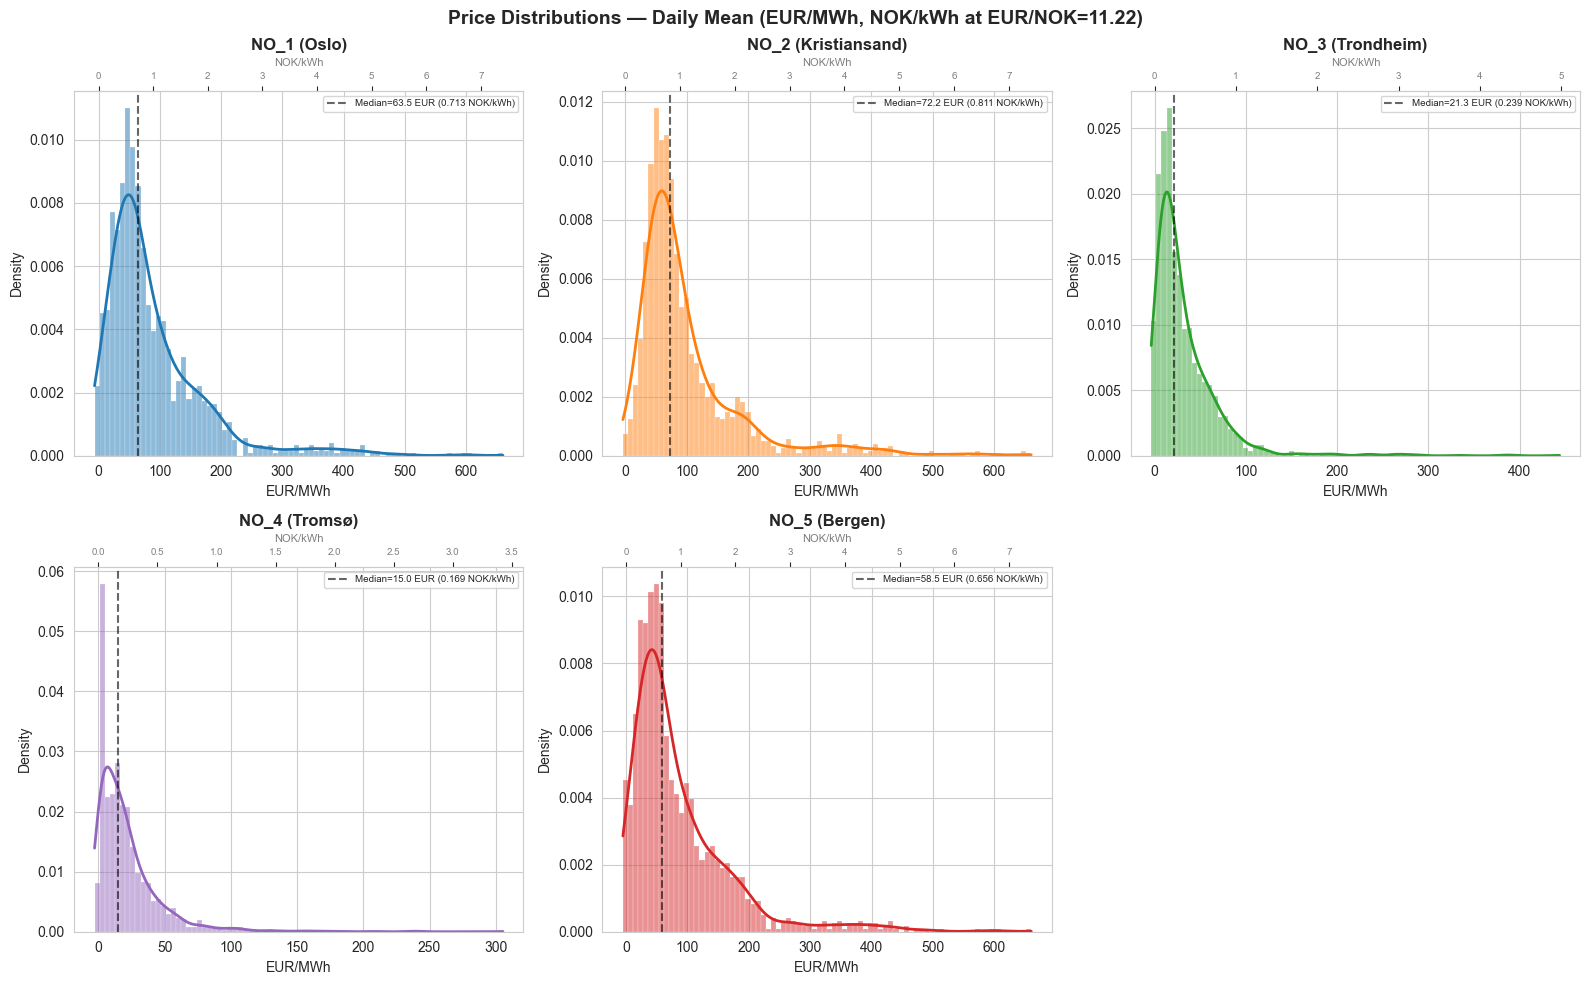

In [5]:
# ── 1b: Histogram + KDE per zone ─────────────────────────────────────

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, z in enumerate(ZONES):
    ax = axes[i]
    s = prices_d[z].dropna()

    ax.hist(s, bins=80, density=True, alpha=0.5, color=ZONE_COLORS[z], edgecolor="white", linewidth=0.3)

    # KDE
    kde_x = np.linspace(s.min(), s.max(), 300)
    kde = stats.gaussian_kde(s)
    ax.plot(kde_x, kde(kde_x), color=ZONE_COLORS[z], linewidth=2)

    ax.set_title(f"{z} ({ZONE_LABELS[z]})", fontsize=12, fontweight="bold")
    ax.set_xlabel("EUR/MWh")
    ax.set_ylabel("Density")
    ax.axvline(s.median(), color="black", linestyle="--", alpha=0.6,
               label=f"Median={s.median():.1f} EUR ({s.median()*AVG_EUR_NOK/1000:.3f} NOK/kWh)")
    ax.legend(fontsize=7)

    # Secondary x-axis for NOK/kWh
    ax2 = ax.secondary_xaxis("top", functions=(
        lambda x: x * AVG_EUR_NOK / 1000,
        lambda x: x * 1000 / AVG_EUR_NOK
    ))
    ax2.set_xlabel("NOK/kWh", fontsize=8, color="gray")
    ax2.tick_params(labelsize=7, labelcolor="gray")

axes[5].set_visible(False)
fig.suptitle(f"Price Distributions — Daily Mean (EUR/MWh, NOK/kWh at EUR/NOK={AVG_EUR_NOK:.2f})",
             fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [6]:
# ── 1c: Normality tests ──────────────────────────────────────────────

print("NORMALITY TESTS (daily mean prices)")
print("-" * 75)
print(f"{'Zone':<20} {'Shapiro-Wilk W':>14} {'p-value':>12} {'Anderson-Darling':>18} {'Normal?':>10}")
print("-" * 75)

for z in ZONES:
    s = prices_d[z].dropna()
    # Shapiro-Wilk (use subsample if > 5000)
    sample = s.sample(min(5000, len(s)), random_state=42)
    sw_stat, sw_p = stats.shapiro(sample)
    # Anderson-Darling
    ad_result = stats.anderson(s, dist="norm")
    ad_stat = ad_result.statistic
    normal = "No" if sw_p < 0.05 else "Yes"
    print(f"{z} ({ZONE_LABELS[z]})  {sw_stat:>12.6f}  {sw_p:>12.2e}  {ad_stat:>16.4f}  {normal:>10}")

print("\nAll zones reject normality at p < 0.05 (as expected for electricity prices).")

NORMALITY TESTS (daily mean prices)
---------------------------------------------------------------------------
Zone                 Shapiro-Wilk W      p-value   Anderson-Darling    Normal?
---------------------------------------------------------------------------
NO_1 (Oslo)      0.780277      1.78e-40           79.2209          No
NO_2 (Kristiansand)      0.723803      7.02e-44          117.3634          No
NO_3 (Trondheim)      0.650932      1.64e-47          103.0583          No
NO_4 (Tromsø)      0.694841      2.08e-45           94.0464          No
NO_5 (Bergen)      0.773958      6.85e-41           82.9274          No

All zones reject normality at p < 0.05 (as expected for electricity prices).


/var/folders/_2/_llw2n8s67n_9kq4z4d57vvr0000gn/T/ipykernel_22266/363829397.py:14: FutureWarning: As of SciPy 1.17, users must choose a p-value calculation method by providing the `method` parameter. `method='interpolate'` interpolates the p-value from pre-calculated tables; `method` may also be an instance of `MonteCarloMethod` to approximate the p-value via Monte Carlo simulation. When `method` is specified, the result object will include a `pvalue` attribute and not attributes `critical_value`, `significance_level`, or `fit_result`. Beginning in 1.19.0, these other attributes will no longer be available, and a p-value will always be computed according to one of the available `method` options.
  ad_result = stats.anderson(s, dist="norm")


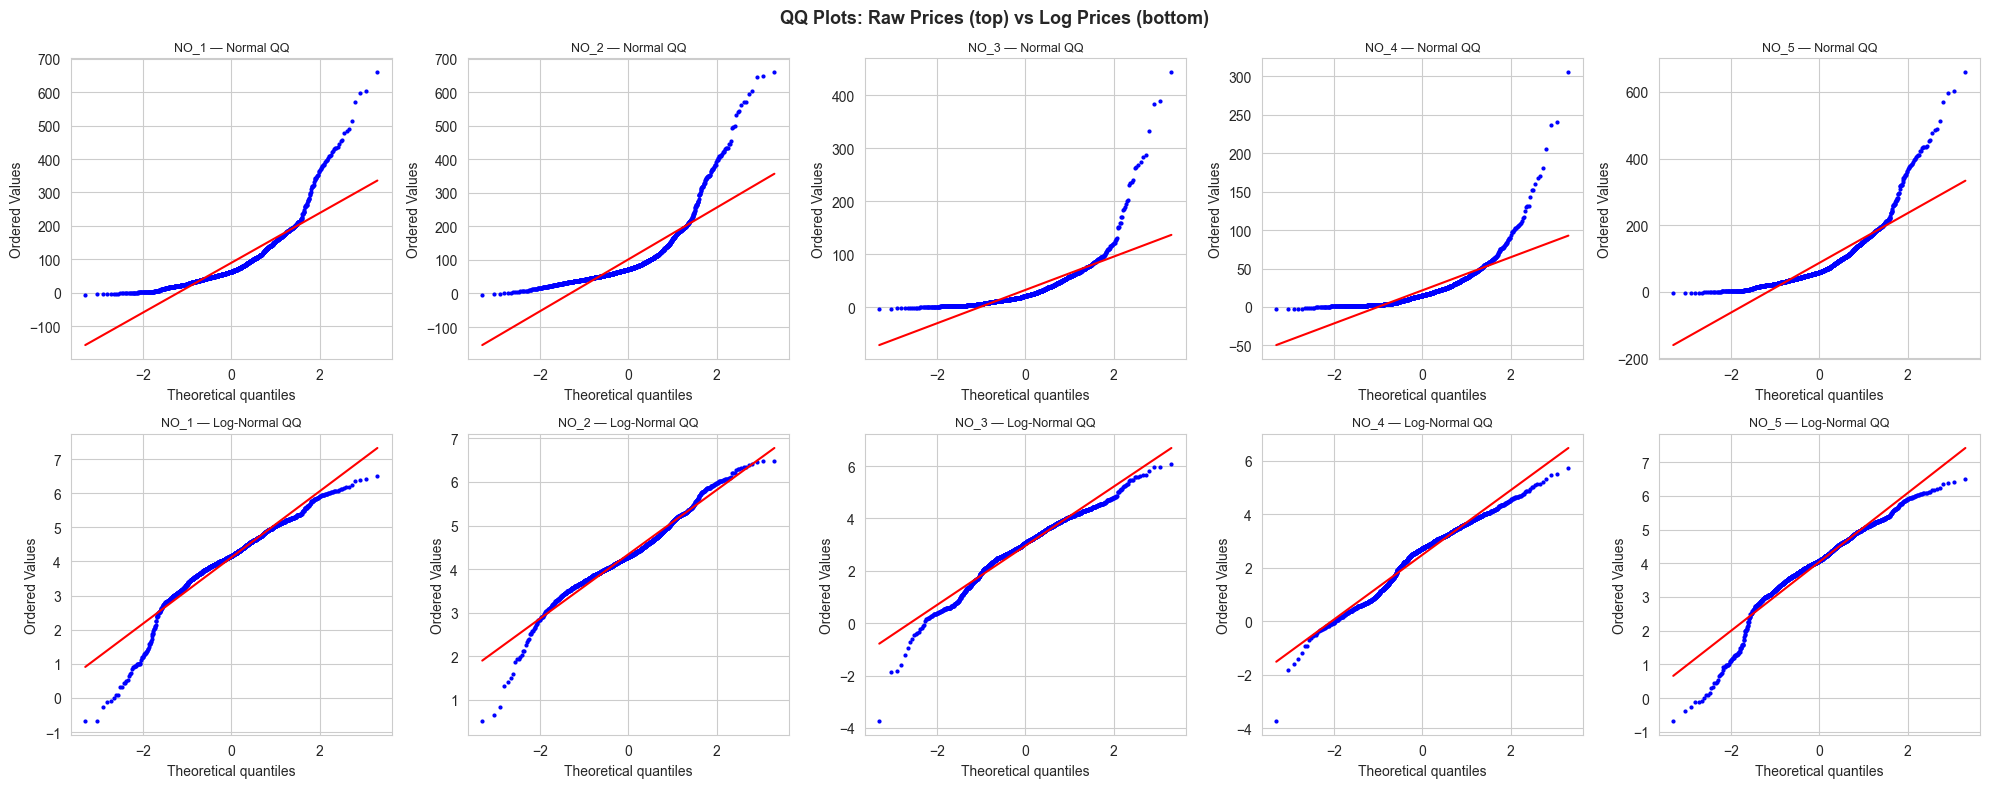

Log-normal QQ is closer to the diagonal → log transformation improves normality.


In [7]:
# ── 1d: QQ plots — Normal vs Log-Normal ──────────────────────────────

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i, z in enumerate(ZONES):
    s = prices_d[z].dropna()
    s_pos = s[s > 0]  # log requires positive

    # Normal QQ
    ax = axes[0, i]
    stats.probplot(s, dist="norm", plot=ax)
    ax.set_title(f"{z} — Normal QQ", fontsize=9)
    ax.get_lines()[0].set_markersize(2)

    # Log-Normal QQ
    ax = axes[1, i]
    stats.probplot(np.log(s_pos), dist="norm", plot=ax)
    ax.set_title(f"{z} — Log-Normal QQ", fontsize=9)
    ax.get_lines()[0].set_markersize(2)

fig.suptitle("QQ Plots: Raw Prices (top) vs Log Prices (bottom)", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()
print("Log-normal QQ is closer to the diagonal → log transformation improves normality.")

---
## 2. Seasonal Decomposition (STL)

### STL Decomposition

STL (Seasonal and Trend decomposition using Loess) decomposes a time series into three additive components:

$$Y_t = T_t + S_t + R_t$$

where:
- $Y_t$ = observed value at time t (daily mean price)
- $T_t$ = trend component (long-term level changes, estimated by LOESS smoother)
- $S_t$ = seasonal component (repeating pattern with fixed period)
- $R_t$ = residual (everything not captured by trend or season — noise, anomalies, events)

**Period** = the cycle length. We use period=7 (weekly) because electricity demand drops on weekends.

**Seasonal strength** quantifies how much of the non-trend variation is explained by the seasonal pattern:

$$F_S = \frac{\text{Var}(S_t)}{\text{Var}(S_t) + \text{Var}(R_t)}$$

- Close to 1 = strong seasonal pattern (price varies predictably by day of week)
- Close to 0 = weak seasonal pattern (price is dominated by other factors)

`statsmodels.tsa.seasonal.STL(data, period=7, robust=True)` — [docs](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.STL.html)

The `robust=True` flag uses LOESS with iterative reweighting, making the decomposition less sensitive to outliers (price spikes).

### Kruskal-Wallis H Test

Non-parametric alternative to one-way ANOVA. Tests whether samples from different groups (here: days of the week) come from the same distribution.

$$H = \frac{12}{N(N+1)} \sum_{j=1}^{k} \frac{R_j^2}{n_j} - 3(N+1)$$

where:
- $k$ = number of groups (7 days)
- $n_j$ = number of observations in group j
- $R_j$ = sum of ranks in group j
- $N$ = total number of observations

- H₀: all groups have the same median (day of week doesn't matter)
- H₁: at least one group differs significantly
- If p < 0.05 → reject H₀ → day of week significantly affects price

Why Kruskal-Wallis instead of ANOVA? Because electricity prices are non-normal (Section 1). Kruskal-Wallis works on **ranks**, making no distributional assumptions.

`scipy.stats.kruskal(*groups)` — [docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html)

### What each cell below provides
- **2a:** STL decomposition plots (observed → trend + seasonal + residual) per zone, seasonal strength metric
- **2b:** Box plots of price by day-of-week per zone, Kruskal-Wallis H-test to confirm significance

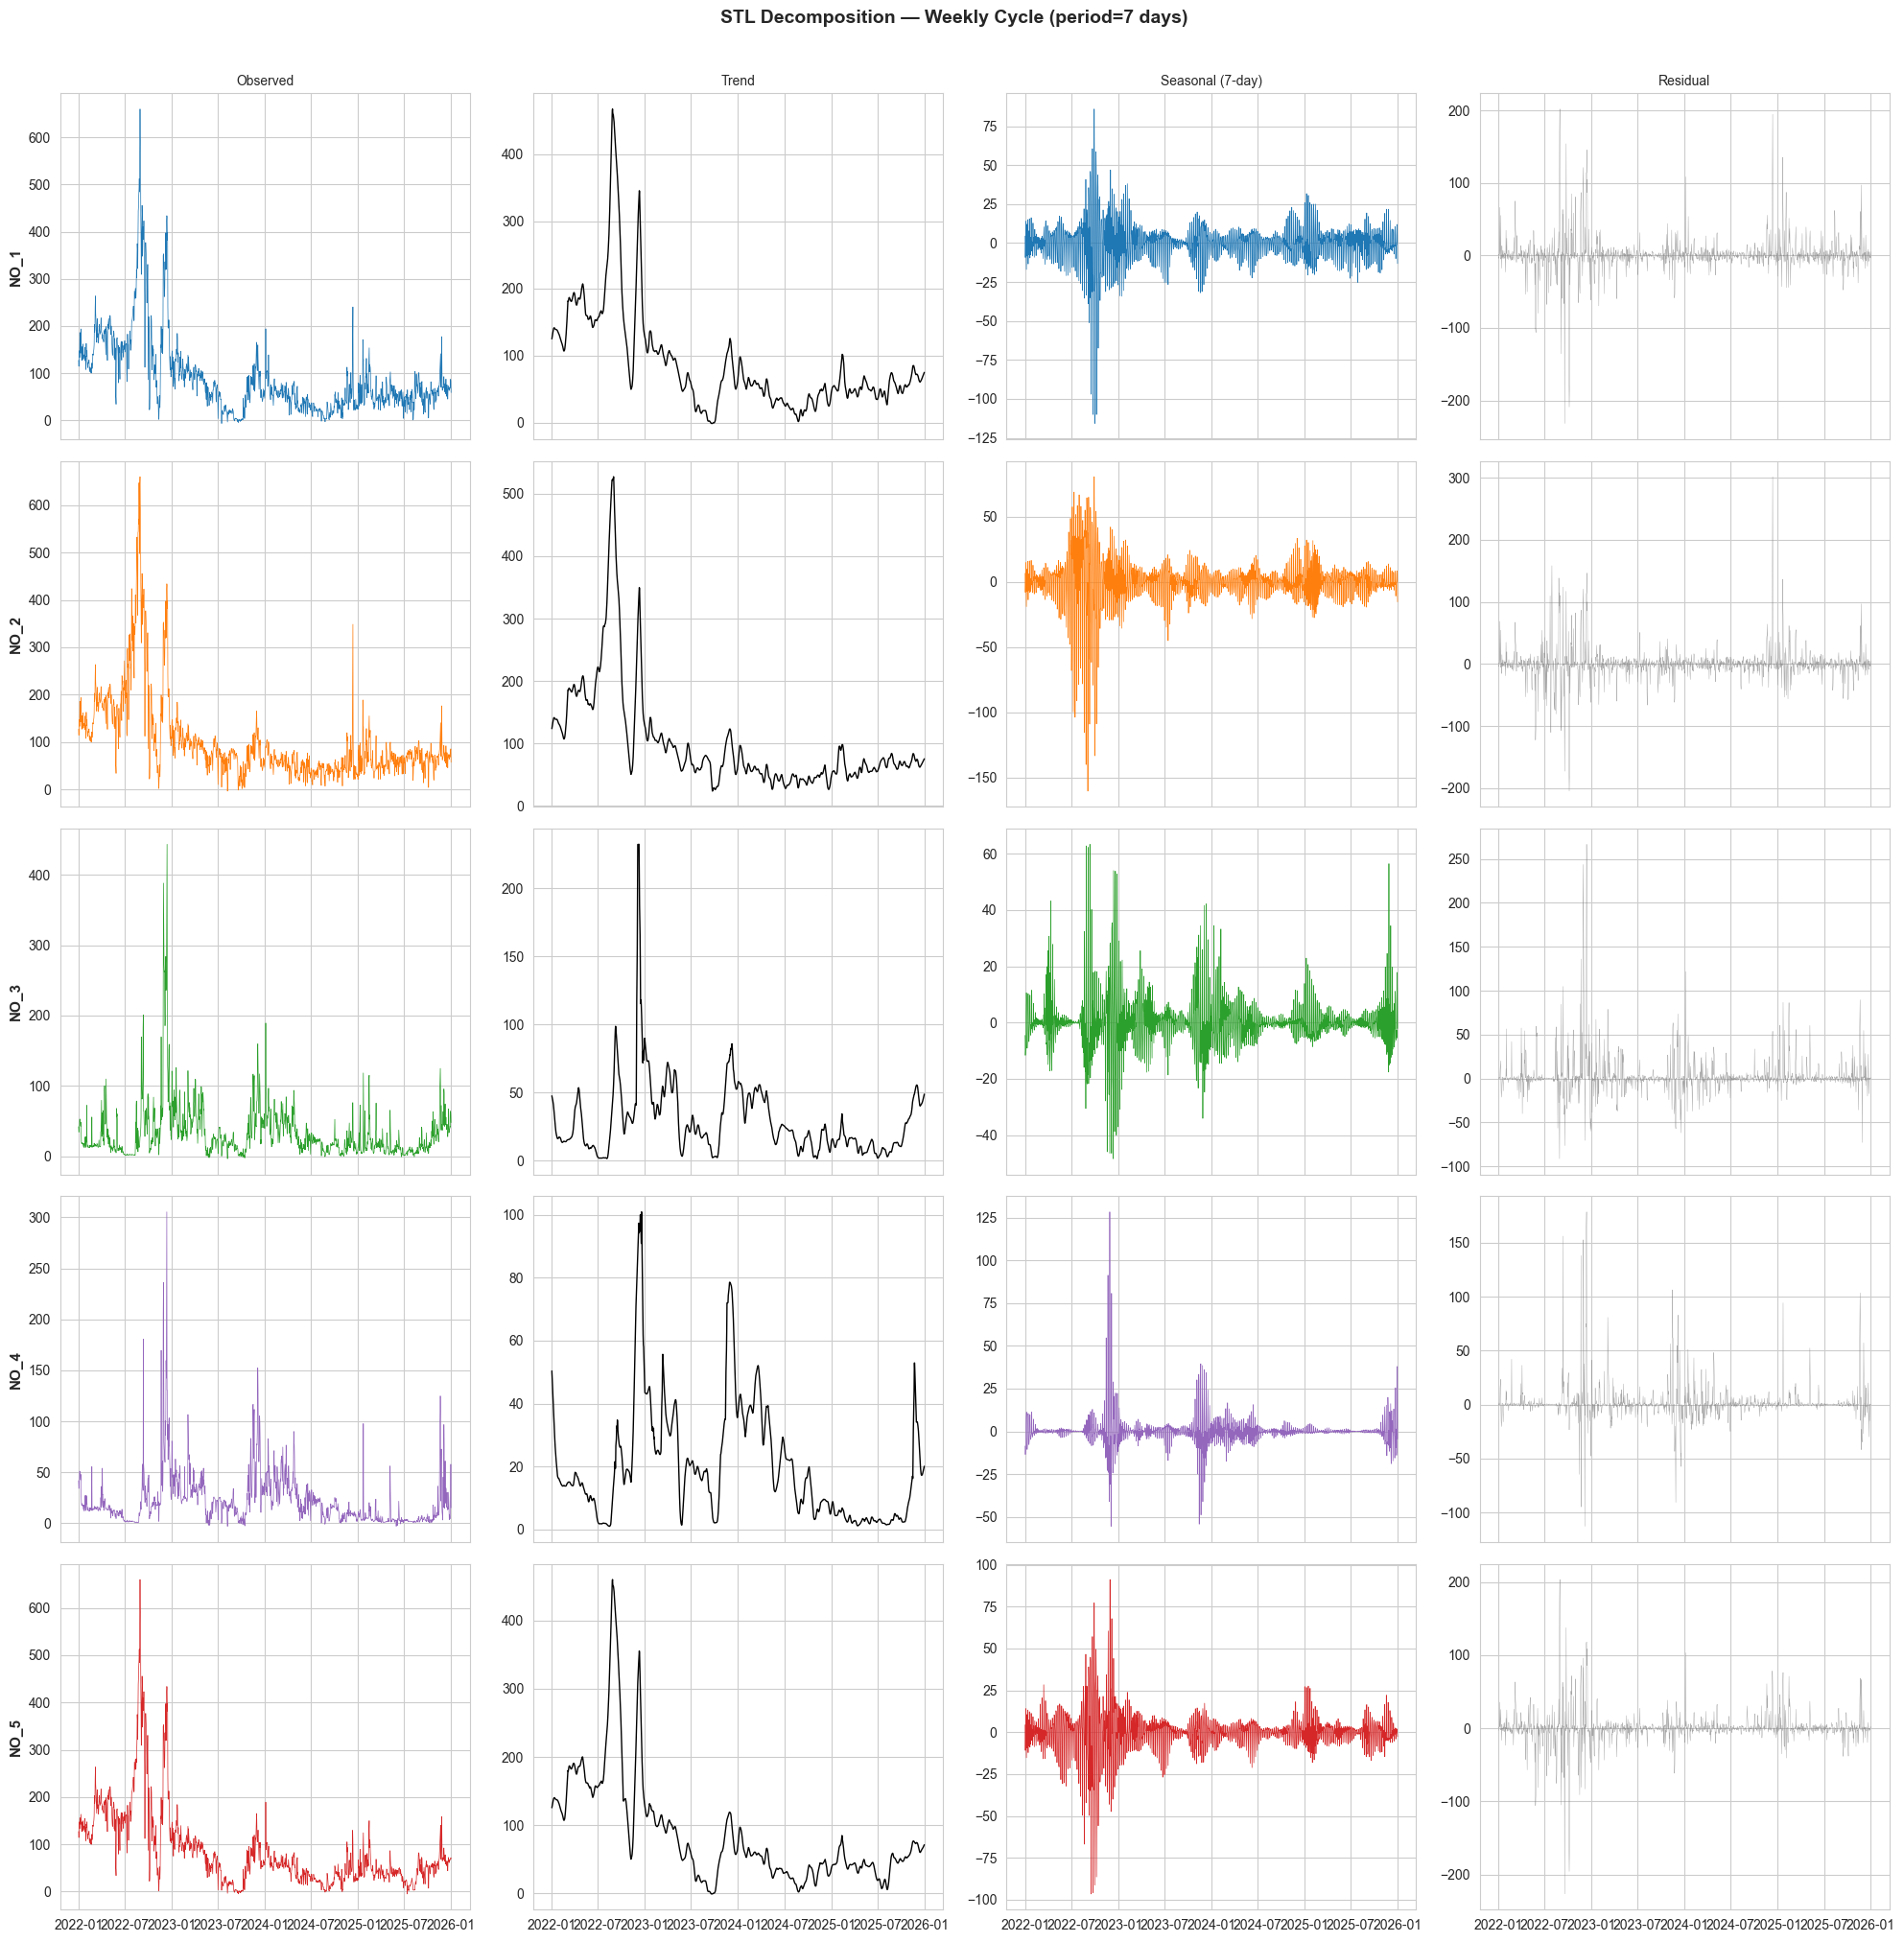


Weekly Seasonal Strength (var_seasonal / var_{seasonal+residual}):
  NO_1 (Oslo): 0.215
  NO_2 (Kristiansand): 0.305
  NO_3 (Trondheim): 0.150
  NO_4 (Tromsø): 0.197
  NO_5 (Bergen): 0.229

Higher = stronger weekly pattern. Southern zones (NO1/NO2) typically show stronger weekly cycles.


In [8]:
# ── 2a: STL decomposition — weekly cycle ─────────────────────────────

fig, axes = plt.subplots(5, 4, figsize=(20, 20), sharex="col")

seasonal_strength = {}

for i, z in enumerate(ZONES):
    s = prices_d[z].dropna()
    # STL requires no missing values — interpolate small gaps
    s = s.interpolate(method="time", limit=3)
    s = s.dropna()

    stl = STL(s, period=7, robust=True)
    result = stl.fit()

    # Seasonal strength: var(seasonal) / var(seasonal + residual)
    var_seas = result.seasonal.var()
    var_resid = result.resid.var()
    strength = var_seas / (var_seas + var_resid)
    seasonal_strength[z] = strength

    axes[i, 0].plot(s.index, s.values, color=ZONE_COLORS[z], linewidth=0.5)
    axes[i, 0].set_ylabel(z, fontsize=11, fontweight="bold")
    if i == 0:
        axes[i, 0].set_title("Observed", fontsize=10)

    axes[i, 1].plot(s.index, result.trend, color="black", linewidth=1)
    if i == 0:
        axes[i, 1].set_title("Trend", fontsize=10)

    axes[i, 2].plot(s.index, result.seasonal, color=ZONE_COLORS[z], linewidth=0.5)
    if i == 0:
        axes[i, 2].set_title("Seasonal (7-day)", fontsize=10)

    axes[i, 3].plot(s.index, result.resid, color="gray", linewidth=0.3, alpha=0.7)
    if i == 0:
        axes[i, 3].set_title("Residual", fontsize=10)

fig.suptitle("STL Decomposition — Weekly Cycle (period=7 days)", fontsize=14, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

print("\nWeekly Seasonal Strength (var_seasonal / var_{seasonal+residual}):")
for z, v in seasonal_strength.items():
    print(f"  {z} ({ZONE_LABELS[z]}): {v:.3f}")
print("\nHigher = stronger weekly pattern. Southern zones (NO1/NO2) typically show stronger weekly cycles.")

KRUSKAL-WALLIS TEST: Is day-of-week significant for daily mean price?
------------------------------------------------------------
  NO_1: H=24.94, p=3.50e-04 ***
  NO_2: H=31.18, p=2.34e-05 ***
  NO_3: H=15.97, p=1.39e-02 *
  NO_4: H=11.80, p=6.65e-02 ns
  NO_5: H=16.35, p=1.20e-02 *


/var/folders/_2/_llw2n8s67n_9kq4z4d57vvr0000gn/T/ipykernel_22266/3482156815.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot(groups, labels=DOW_LABELS, patch_artist=True,
/var/folders/_2/_llw2n8s67n_9kq4z4d57vvr0000gn/T/ipykernel_22266/3482156815.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot(groups, labels=DOW_LABELS, patch_artist=True,
/var/folders/_2/_llw2n8s67n_9kq4z4d57vvr0000gn/T/ipykernel_22266/3482156815.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot(groups, labels=DOW_LABELS, patch_artist=True,
/var/folders/_2/_llw2n8s67n_9kq4z4d57

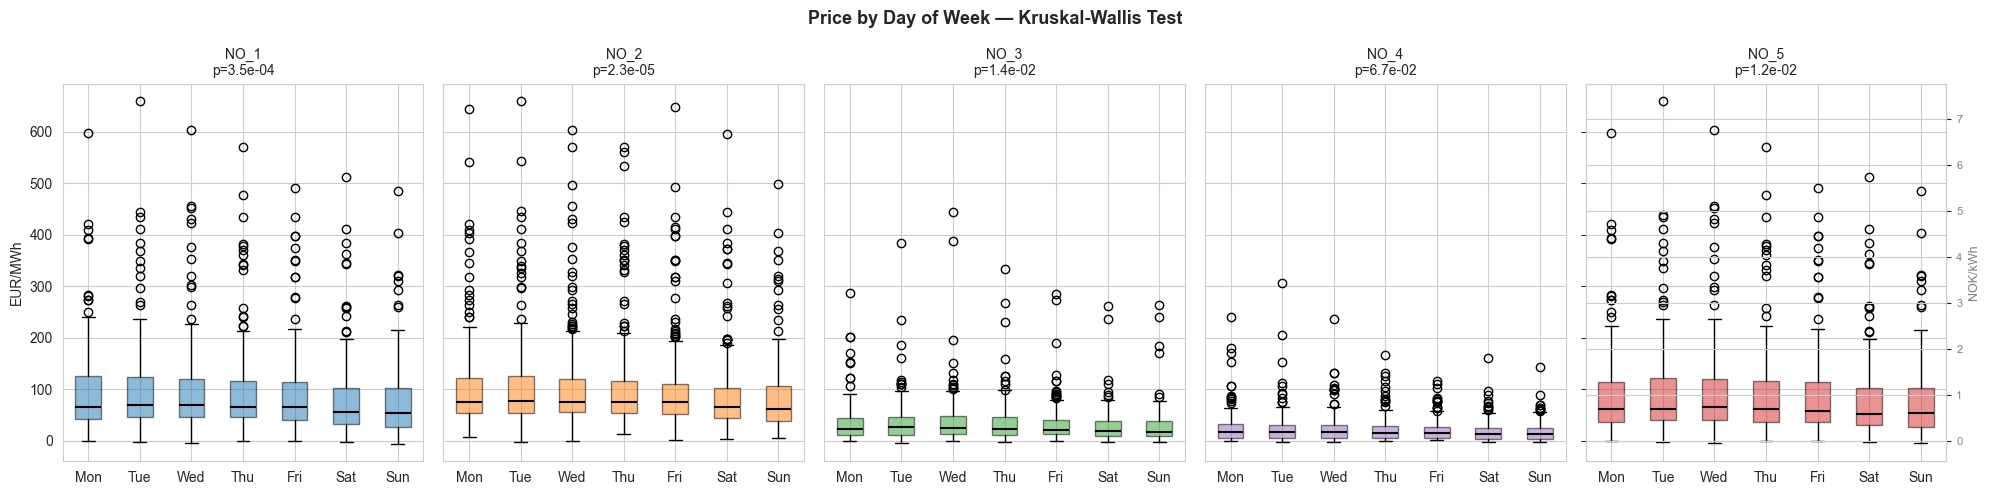


Weekend prices are significantly lower across all zones.
(Right y-axis shows NOK/kWh at avg EUR/NOK = 11.22)


In [9]:
# ── 2b: Day-of-week analysis with Kruskal-Wallis test ────────────────

fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
DOW_LABELS = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

print("KRUSKAL-WALLIS TEST: Is day-of-week significant for daily mean price?")
print("-" * 60)

for i, z in enumerate(ZONES):
    s = prices_d[z].dropna()
    dow = s.index.dayofweek

    groups = [s[dow == d].values for d in range(7)]
    kw_stat, kw_p = stats.kruskal(*groups)
    sig = "***" if kw_p < 0.001 else ("**" if kw_p < 0.01 else ("*" if kw_p < 0.05 else "ns"))
    print(f"  {z}: H={kw_stat:.2f}, p={kw_p:.2e} {sig}")

    bp = axes[i].boxplot(groups, labels=DOW_LABELS, patch_artist=True,
                         medianprops={"color": "black", "linewidth": 1.5})
    for patch in bp["boxes"]:
        patch.set_facecolor(ZONE_COLORS[z])
        patch.set_alpha(0.5)
    axes[i].set_title(f"{z}\np={kw_p:.1e}", fontsize=10)
    if i == 0:
        axes[i].set_ylabel("EUR/MWh")

# Add NOK/kWh axis to rightmost plot
add_nok_axis(axes[-1])

fig.suptitle("Price by Day of Week — Kruskal-Wallis Test", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()
print(f"\nWeekend prices are significantly lower across all zones.")
print(f"(Right y-axis shows NOK/kWh at avg EUR/NOK = {AVG_EUR_NOK:.2f})")

---
## 3. Reservoir Deep Dive

Norway is ~95% hydro-powered. Reservoir filling directly affects supply and price.
This section tests whether reservoir changes *Granger-cause* price changes, and
quantifies the reservoir-price relationship per zone.

### Spearman Rank Correlation (ρ)

Measures **monotonic** (not just linear) association between two variables:

$$\rho_s = 1 - \frac{6 \sum d_i^2}{n(n^2 - 1)}$$

where $d_i$ = difference between the ranks of each paired observation.

- ρ = +1: perfect positive monotonic relationship
- ρ = −1: perfect negative monotonic (as reservoir fills up, price always drops)
- ρ = 0: no monotonic relationship

**Why Spearman instead of Pearson?** Pearson measures *linear* correlation only. The reservoir-price relationship is likely non-linear — prices spike when reservoirs are very low, but don't drop proportionally when very high. Spearman captures this because it operates on ranks, not raw values.

`scipy.stats.spearmanr(x, y)` — [docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html)

### Granger Causality Test

Tests whether past values of X help predict Y **beyond** what past values of Y alone can predict.

For lag $p$, it compares two autoregressive models:
- **Restricted:** $Y_t = \alpha + \sum_{i=1}^{p} \beta_i Y_{t-i} + \epsilon_t$ (only own past)
- **Unrestricted:** $Y_t = \alpha + \sum_{i=1}^{p} \beta_i Y_{t-i} + \sum_{i=1}^{p} \gamma_i X_{t-i} + \epsilon_t$ (own past + X's past)

Then uses an F-test on whether adding X significantly reduces prediction error:

$$F = \frac{(SSR_{\text{restricted}} - SSR_{\text{unrestricted}}) / p}{SSR_{\text{unrestricted}} / (n - 2p - 1)}$$

- H₀: X does NOT Granger-cause Y (all γ coefficients are zero)
- H₁: X does Granger-cause Y (at least one γ is nonzero)
- If p < 0.05 → reservoir changes help predict future price changes

**Important caveat:** Granger causality is **not true causality** — it only tests predictive usefulness. Both reservoir filling and prices are driven by underlying factors (weather, demand). But if reservoir info improves price forecasts, it's a useful feature.

`statsmodels.tsa.stattools.grangercausalitytests(data, maxlag)` — [docs](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.grangercausalitytests.html)

### Linear Regression (OLS fit line)

$$\hat{y} = \beta_0 + \beta_1 x$$

- **slope (β₁):** how much price changes per percentage point of reservoir deviation from median
- **R²:** proportion of price variance explained by reservoir deviation (0 = none, 1 = all)

`scipy.stats.linregress(x, y)` — [docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html)

### What each cell below provides
- **3a:** Reservoir filling trajectories with 20-year historical min/max/median benchmark bands per zone
- **3b:** Spearman correlation (filling % vs weekly price) per zone with p-values
- **3c:** Granger causality F-test at lags 1–8 weeks (does reservoir *change* predict price *change*?)
- **3d:** Scatter plots of reservoir deviation from median vs price, with OLS fit line and R²

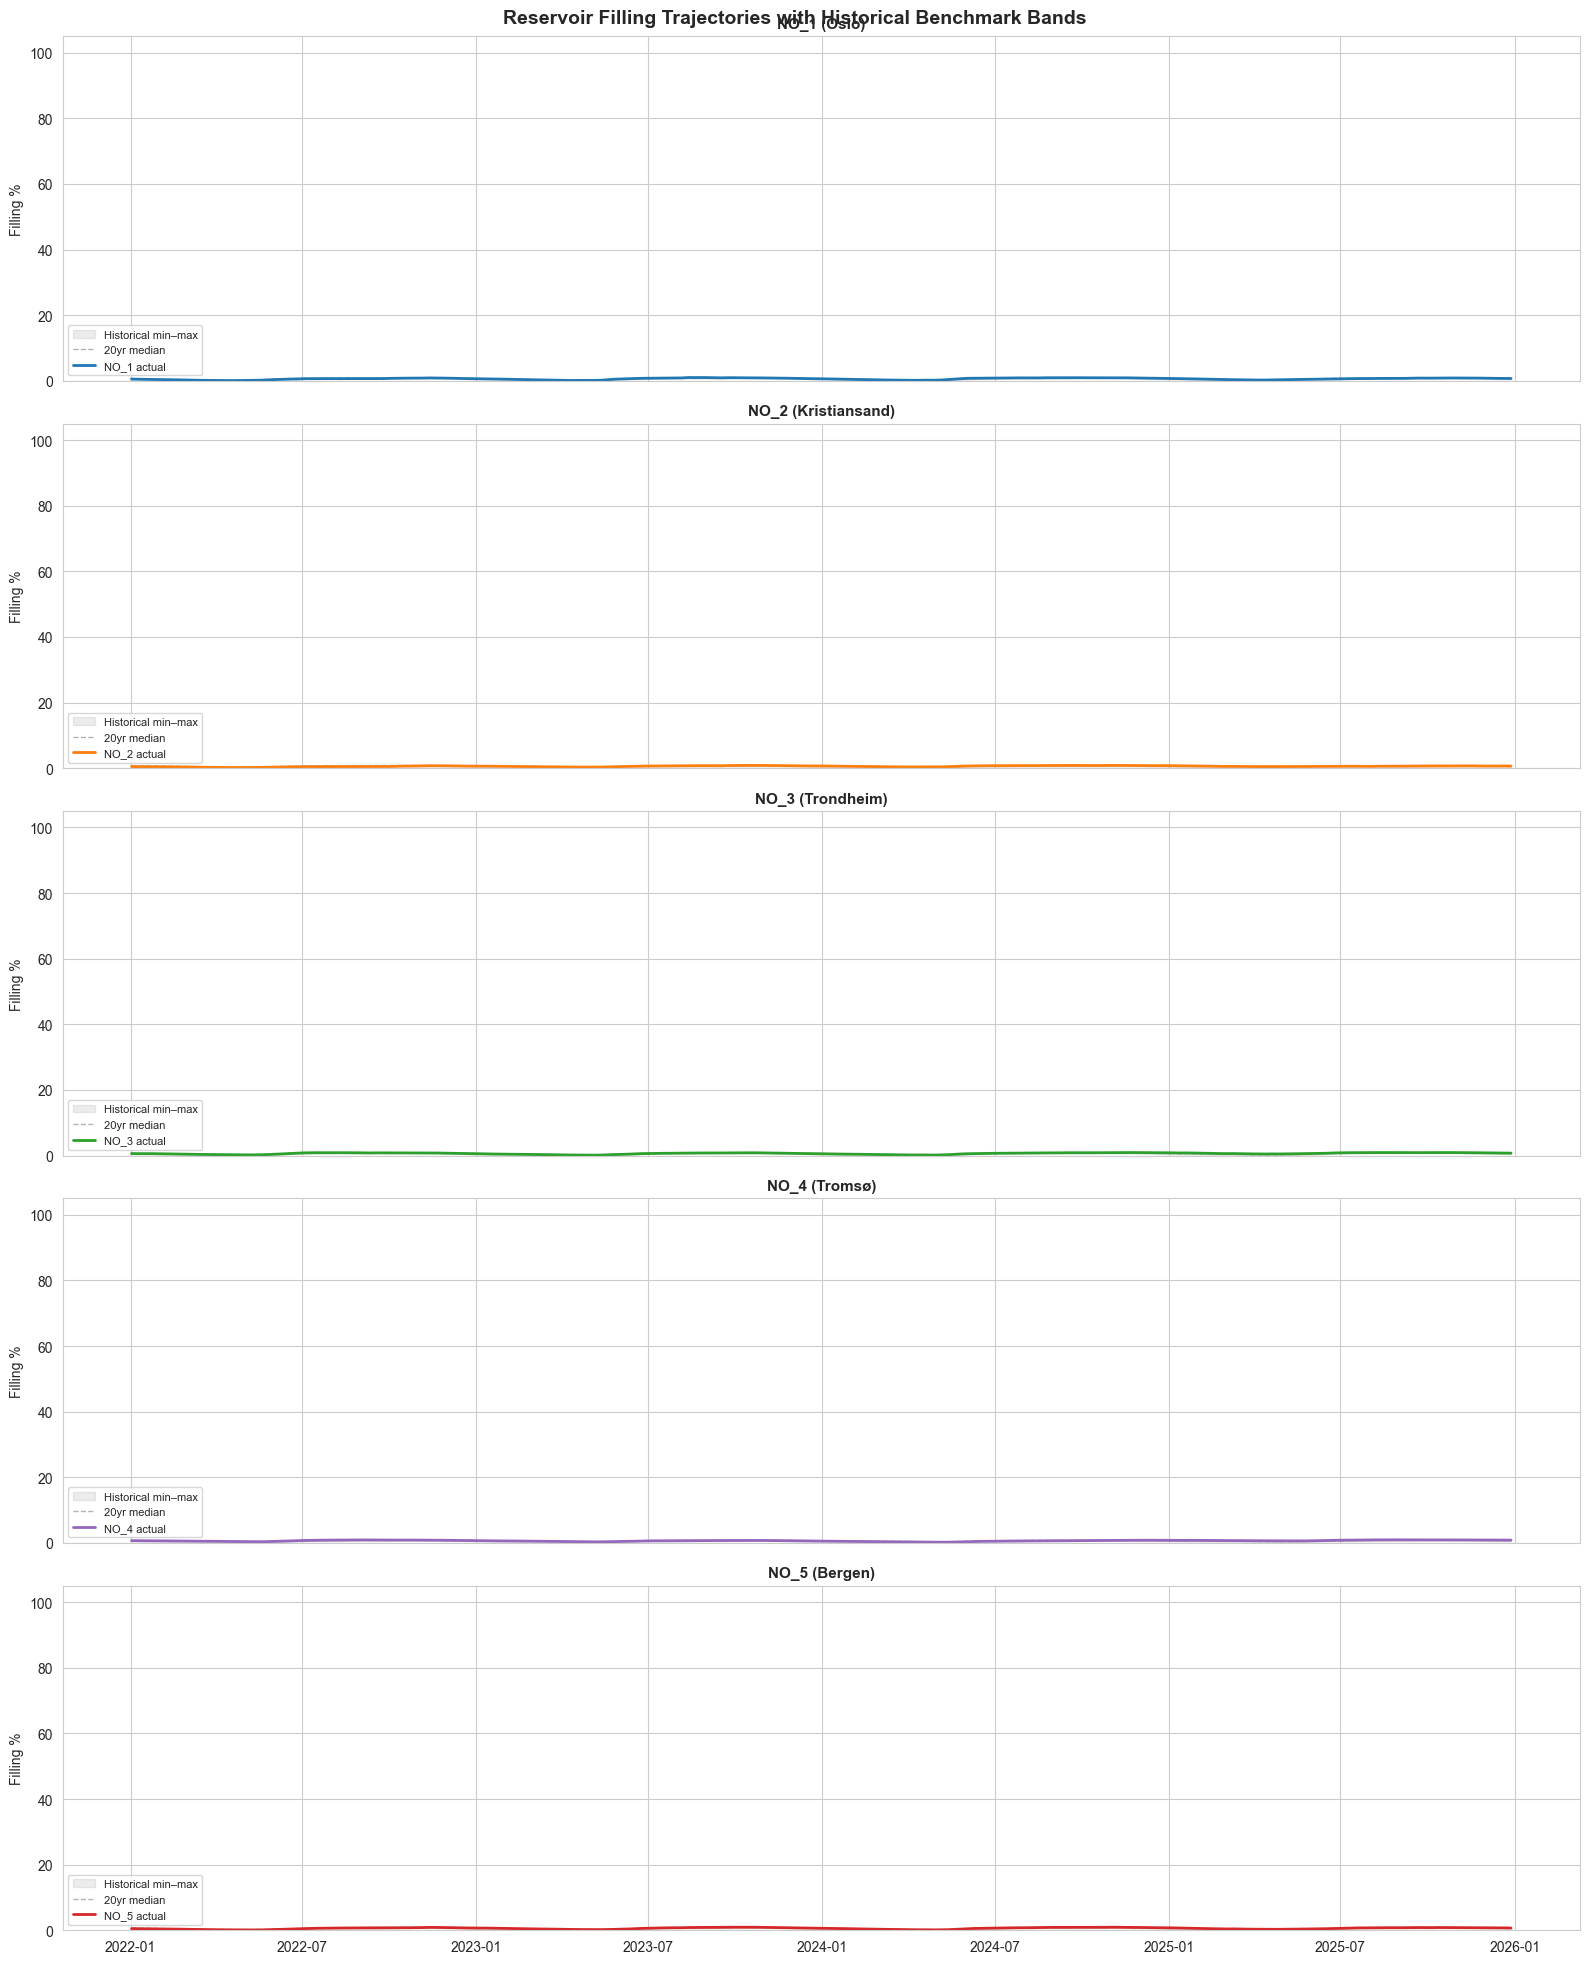

In [10]:
# ── 3a: Reservoir trajectories with benchmark bands ──────────────────

fig, axes = plt.subplots(5, 1, figsize=(16, 20), sharex=True)

for i, z in enumerate(ZONES):
    ax = axes[i]
    if z not in reservoir:
        ax.text(0.5, 0.5, f"No reservoir data for {z}", transform=ax.transAxes, ha="center")
        continue

    r = reservoir[z]

    # Min/max band
    if "filling_vs_min" in r.columns and "filling_vs_max" in r.columns:
        min_fill = r["filling_pct"] - r["filling_vs_min"]
        max_fill = r["filling_pct"] - r["filling_vs_max"]
        # filling_vs_min = filling - historical_min (positive = above min)
        # filling_vs_max = filling - historical_max (negative = below max)
        hist_min = r["filling_pct"] - r["filling_vs_min"]
        hist_max = r["filling_pct"] - r["filling_vs_max"]
        ax.fill_between(r.index, hist_min, hist_max, alpha=0.15, color="gray", label="Historical min–max")

    if "filling_vs_median" in r.columns:
        hist_median = r["filling_pct"] - r["filling_vs_median"]
        ax.plot(r.index, hist_median, color="gray", linestyle="--", linewidth=1, alpha=0.6, label="20yr median")

    ax.plot(r.index, r["filling_pct"], color=ZONE_COLORS[z], linewidth=2, label=f"{z} actual")
    ax.set_ylabel("Filling %")
    ax.set_title(f"{z} ({ZONE_LABELS[z]})", fontsize=11, fontweight="bold")
    ax.legend(fontsize=8, loc="lower left")
    ax.set_ylim(0, 105)

fig.suptitle("Reservoir Filling Trajectories with Historical Benchmark Bands", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [11]:
# ── 3b: Reservoir-price correlation (Spearman) ───────────────────────

print("RESERVOIR–PRICE SPEARMAN CORRELATION (weekly data)")
print("-" * 70)
print(f"{'Zone':<20} {'ρ (filling vs price)':>22} {'p-value':>12} {'Sig?':>6}")
print("-" * 70)

res_price_corr = {}
for z in ZONES:
    if z not in reservoir:
        continue
    r = reservoir[z][["filling_pct"]].copy()
    if r.index.tz is not None:
        r.index = r.index.tz_localize(None)

    # Match prices to reservoir weeks
    p_weekly = prices_d[z].resample("W").mean()
    merged = pd.concat([r["filling_pct"], p_weekly.rename("price")], axis=1).dropna()

    if len(merged) < 10:
        print(f"  {z}: insufficient data ({len(merged)} weeks)")
        continue

    rho, p = stats.spearmanr(merged["filling_pct"], merged["price"])
    res_price_corr[z] = rho
    sig = "***" if p < 0.001 else ("**" if p < 0.01 else ("*" if p < 0.05 else "ns"))
    print(f"  {z} ({ZONE_LABELS[z]})     {rho:>+.4f}              {p:.2e}    {sig}")

print("\nExpected: negative correlation — higher filling → lower prices (more hydro supply).")
print("Stronger for hydro-heavy zones (NO2, NO5).")

RESERVOIR–PRICE SPEARMAN CORRELATION (weekly data)
----------------------------------------------------------------------
Zone                   ρ (filling vs price)      p-value   Sig?
----------------------------------------------------------------------
  NO_1 (Oslo)     -0.5072              4.59e-15    ***
  NO_2 (Kristiansand)     -0.5288              1.88e-16    ***
  NO_3 (Trondheim)     -0.4192              2.65e-10    ***
  NO_4 (Tromsø)     -0.4569              3.55e-12    ***
  NO_5 (Bergen)     -0.4061              1.06e-09    ***

Expected: negative correlation — higher filling → lower prices (more hydro supply).
Stronger for hydro-heavy zones (NO2, NO5).


In [12]:
# ── 3c: Granger causality — Does reservoir change predict price change?

print("GRANGER CAUSALITY: reservoir filling change → price change")
print("Testing lags 1–8 weeks. H0: reservoir change does NOT Granger-cause price change.")
print("=" * 80)

for z in ZONES:
    if z not in reservoir:
        continue

    r = reservoir[z][["filling_change"]].copy()
    if r.index.tz is not None:
        r.index = r.index.tz_localize(None)

    p_weekly = prices_d[z].resample("W").mean().diff().rename("price_change")
    merged = pd.concat([p_weekly, r["filling_change"]], axis=1).dropna()

    if len(merged) < 20:
        print(f"  {z}: insufficient data")
        continue

    print(f"\n{z} ({ZONE_LABELS[z]}) — {len(merged)} weekly observations:")
    try:
        gc = grangercausalitytests(merged[["price_change", "filling_change"]], maxlag=8, verbose=False)
        for lag in range(1, 9):
            f_stat = gc[lag][0]["ssr_ftest"][0]
            p_val = gc[lag][0]["ssr_ftest"][1]
            sig = "*" if p_val < 0.05 else ""
            print(f"  Lag {lag} weeks: F={f_stat:>7.3f}, p={p_val:.4f} {sig}")
    except Exception as e:
        print(f"  Error: {e}")

print("\n* = significant at p < 0.05 → reservoir change helps predict future price change.")

GRANGER CAUSALITY: reservoir filling change → price change
Testing lags 1–8 weeks. H0: reservoir change does NOT Granger-cause price change.

NO_1 (Oslo) — 208 weekly observations:
  Lag 1 weeks: F=  0.647, p=0.4222 
  Lag 2 weeks: F=  0.278, p=0.7579 
  Lag 3 weeks: F=  0.197, p=0.8981 
  Lag 4 weeks: F=  0.077, p=0.9892 
  Lag 5 weeks: F=  0.134, p=0.9845 
  Lag 6 weeks: F=  0.106, p=0.9956 
  Lag 7 weeks: F=  0.375, p=0.9159 
  Lag 8 weeks: F=  0.631, p=0.7513 

NO_2 (Kristiansand) — 208 weekly observations:
  Lag 1 weeks: F=  7.344, p=0.0073 *
  Lag 2 weeks: F=  4.873, p=0.0086 *
  Lag 3 weeks: F=  4.514, p=0.0044 *
  Lag 4 weeks: F=  3.202, p=0.0142 *
  Lag 5 weeks: F=  2.451, p=0.0352 *
  Lag 6 weeks: F=  2.033, p=0.0633 
  Lag 7 weeks: F=  1.980, p=0.0599 
  Lag 8 weeks: F=  1.640, p=0.1162 

NO_3 (Trondheim) — 208 weekly observations:
  Lag 1 weeks: F=  0.764, p=0.3830 
  Lag 2 weeks: F=  0.247, p=0.7815 
  Lag 3 weeks: F=  0.258, p=0.8554 
  Lag 4 weeks: F=  0.258, p=0.9044 
 

/Users/martin/Documents/GitHub/electricity_forecast/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/martin/Documents/GitHub/electricity_forecast/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/martin/Documents/GitHub/electricity_forecast/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/martin/Documents/GitHub/electricity_forecast/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/martin/Documents/GitHub/electricity_forecast/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarn

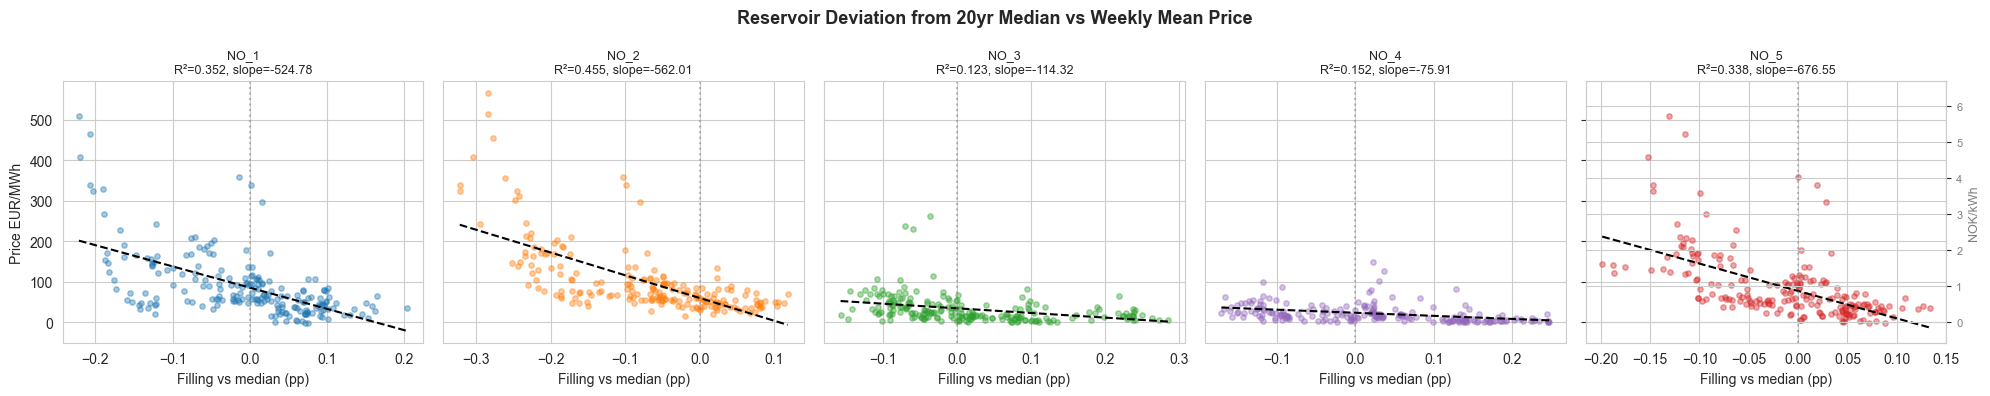

Negative slope = below-median filling → higher prices. Stronger effect in hydro-dependent zones.
(Right y-axis shows NOK/kWh at avg EUR/NOK = 11.22)


In [13]:
# ── 3d: Reservoir deviation from median vs price ─────────────────────

fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

for i, z in enumerate(ZONES):
    ax = axes[i]
    if z not in reservoir or "filling_vs_median" not in reservoir[z].columns:
        ax.text(0.5, 0.5, "No data", transform=ax.transAxes, ha="center")
        continue

    r = reservoir[z][["filling_vs_median"]].copy()
    if r.index.tz is not None:
        r.index = r.index.tz_localize(None)

    p_weekly = prices_d[z].resample("W").mean().rename("price")
    merged = pd.concat([r, p_weekly], axis=1).dropna()

    ax.scatter(merged["filling_vs_median"], merged["price"],
               alpha=0.4, s=15, color=ZONE_COLORS[z])

    # OLS fit line
    if len(merged) > 10:
        slope, intercept, r_val, p_val, _ = stats.linregress(
            merged["filling_vs_median"], merged["price"]
        )
        x_fit = np.linspace(merged["filling_vs_median"].min(), merged["filling_vs_median"].max(), 50)
        ax.plot(x_fit, intercept + slope * x_fit, color="black", linewidth=1.5, linestyle="--")
        ax.set_title(f"{z}\nR\u00b2={r_val**2:.3f}, slope={slope:.2f}", fontsize=9)

    ax.axvline(0, color="gray", linestyle=":", alpha=0.5)
    ax.set_xlabel("Filling vs median (pp)")
    if i == 0:
        ax.set_ylabel("Price EUR/MWh")

# Add NOK/kWh axis to rightmost plot
add_nok_axis(axes[-1])

fig.suptitle("Reservoir Deviation from 20yr Median vs Weekly Mean Price", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()
print("Negative slope = below-median filling \u2192 higher prices. Stronger effect in hydro-dependent zones.")
print(f"(Right y-axis shows NOK/kWh at avg EUR/NOK = {AVG_EUR_NOK:.2f})")

---
## 4. Export/Import Pattern Analysis

Norway is typically a net electricity exporter (hydro surplus). This section
analyzes when and how much Norway exports, and how this relates to prices.
Uses Statnett physical flow and production/consumption data.

### Pearson Correlation (r)

Measures *linear* association between two continuous variables:

$$r = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum (x_i - \bar{x})^2 \cdot \sum (y_i - \bar{y})^2}}$$

- r = +1: perfect positive linear relationship
- r = −1: perfect negative linear relationship
- r = 0: no linear relationship (but non-linear relationship may still exist!)

**When to use Pearson vs Spearman:**
- **Pearson:** both variables are roughly normally distributed, relationship is linear
- **Spearman:** data is skewed, has outliers, or relationship is monotonic but non-linear
- We report both here — if they differ a lot, the relationship is non-linear

`scipy.stats.pearsonr(x, y)` — [docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)

### Mann-Whitney U Test

Non-parametric test comparing two independent groups (here: prices on export days vs import days):

$$U = R_1 - \frac{n_1(n_1+1)}{2}$$

where $R_1$ = sum of ranks in group 1, $n_1$ = size of group 1.

- H₀: the two groups come from the same distribution
- H₁: one group tends to have higher values than the other
- If p < 0.05 → prices are significantly different between export and import days

Why not a t-test? Because electricity prices are non-normal (Section 1). Mann-Whitney works on **ranks** and makes no distributional assumptions.

`scipy.stats.mannwhitneyu(x, y, alternative='two-sided')` — [docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html)

**Export intensity** = net_exchange / production — what fraction of Norway's electricity production is exported. Negative means net importer.

### What each cell below provides
- **4a:** Net exchange time series (green=export, red=import) + distribution histogram
- **4b:** Monthly seasonal patterns: average net exchange, production vs consumption, export intensity %
- **4c:** Scatter plot (net exchange vs price) with Pearson + Spearman ρ, plus Mann-Whitney U test comparing export vs import day prices

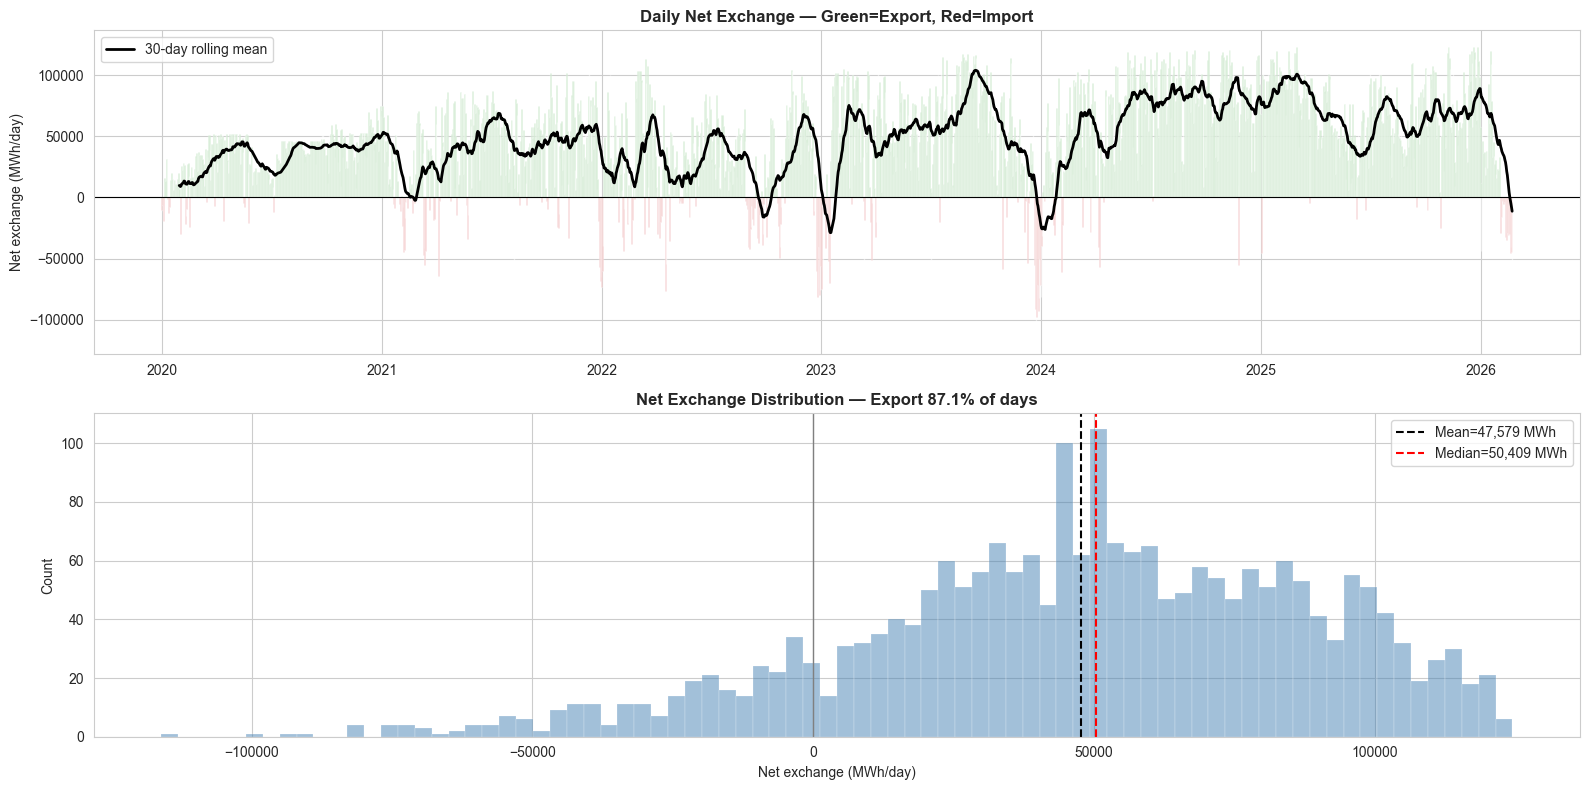

In [14]:
# ── 4a: Net exchange time series & distribution ──────────────────────

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

fe = flows.copy()
if fe.index.tz is not None:
    fe.index = fe.index.tz_localize(None)

# Time series
ax = axes[0]
colors = np.where(fe["net_exchange_mwh"] > 0, "tab:green", "tab:red")
ax.bar(fe.index, fe["net_exchange_mwh"], color=colors, alpha=0.5, width=1)
ax.axhline(0, color="black", linewidth=0.8)
roll30 = fe["net_exchange_mwh"].rolling(30).mean()
ax.plot(fe.index, roll30, color="black", linewidth=2, label="30-day rolling mean")
ax.set_ylabel("Net exchange (MWh/day)")
ax.set_title("Daily Net Exchange — Green=Export, Red=Import", fontweight="bold")
ax.legend()

# Distribution
ax = axes[1]
vals = fe["net_exchange_mwh"].dropna()
ax.hist(vals, bins=80, alpha=0.5, color="steelblue", edgecolor="white", linewidth=0.3)
ax.axvline(vals.mean(), color="black", linestyle="--", linewidth=1.5, label=f"Mean={vals.mean():,.0f} MWh")
ax.axvline(vals.median(), color="red", linestyle="--", linewidth=1.5, label=f"Median={vals.median():,.0f} MWh")
ax.axvline(0, color="gray", linewidth=1)
ax.set_xlabel("Net exchange (MWh/day)")
ax.set_ylabel("Count")
pct_export = (vals > 0).mean() * 100
ax.set_title(f"Net Exchange Distribution — Export {pct_export:.1f}% of days", fontweight="bold")
ax.legend()

plt.tight_layout()
plt.show()

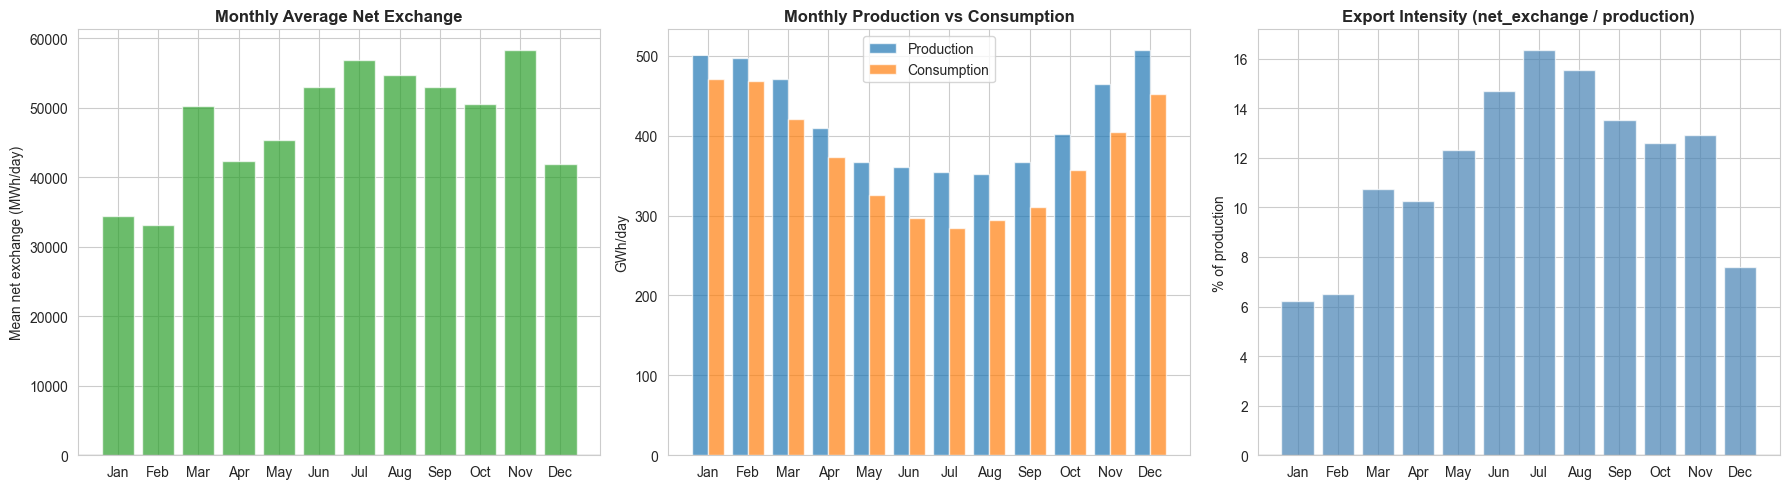

In [15]:
# ── 4b: Seasonal export pattern & production surplus ─────────────────

pc = prod_cons.copy()
if pc.index.tz is not None:
    pc.index = pc.index.tz_localize(None)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Monthly mean net exchange
ax = axes[0]
monthly_exchange = fe["net_exchange_mwh"].groupby(fe.index.month).mean()
colors_bar = ["tab:green" if v > 0 else "tab:red" for v in monthly_exchange]
ax.bar(range(1, 13), monthly_exchange, color=colors_bar, alpha=0.7)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
ax.axhline(0, color="black", linewidth=0.8)
ax.set_ylabel("Mean net exchange (MWh/day)")
ax.set_title("Monthly Average Net Exchange", fontweight="bold")

# Production vs consumption
ax = axes[1]
monthly_prod = pc["production_mwh"].groupby(pc.index.month).mean() / 1e3
monthly_cons = pc["consumption_mwh"].groupby(pc.index.month).mean() / 1e3
x = np.arange(1, 13)
ax.bar(x - 0.2, monthly_prod, width=0.4, label="Production", color="tab:blue", alpha=0.7)
ax.bar(x + 0.2, monthly_cons, width=0.4, label="Consumption", color="tab:orange", alpha=0.7)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
ax.set_ylabel("GWh/day")
ax.set_title("Monthly Production vs Consumption", fontweight="bold")
ax.legend()

# Export intensity: net_exchange / production
ax = axes[2]
pc_merged = pc.join(fe, how="inner")
pc_merged["export_intensity"] = pc_merged["net_exchange_mwh"] / pc_merged["production_mwh"]
monthly_intensity = pc_merged["export_intensity"].groupby(pc_merged.index.month).mean() * 100
ax.bar(range(1, 13), monthly_intensity, color="steelblue", alpha=0.7)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
ax.axhline(0, color="black", linewidth=0.8)
ax.set_ylabel("% of production")
ax.set_title("Export Intensity (net_exchange / production)", fontweight="bold")

plt.tight_layout()
plt.show()

/var/folders/_2/_llw2n8s67n_9kq4z4d57vvr0000gn/T/ipykernel_22266/252502322.py:5: Pandas4Warning: Sorting by default when concatenating all DatetimeIndex is deprecated.  In the future, pandas will respect the default of `sort=False`. Specify `sort=True` or `sort=False` to silence this message. If you see this warnings when not directly calling concat, report a bug to pandas.
  exp_price = pd.concat([fe["net_exchange_mwh"], price_all], axis=1).dropna()
/var/folders/_2/_llw2n8s67n_9kq4z4d57vvr0000gn/T/ipykernel_22266/252502322.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([export_days.values, import_days.values], labels=["Export days", "Import days"],


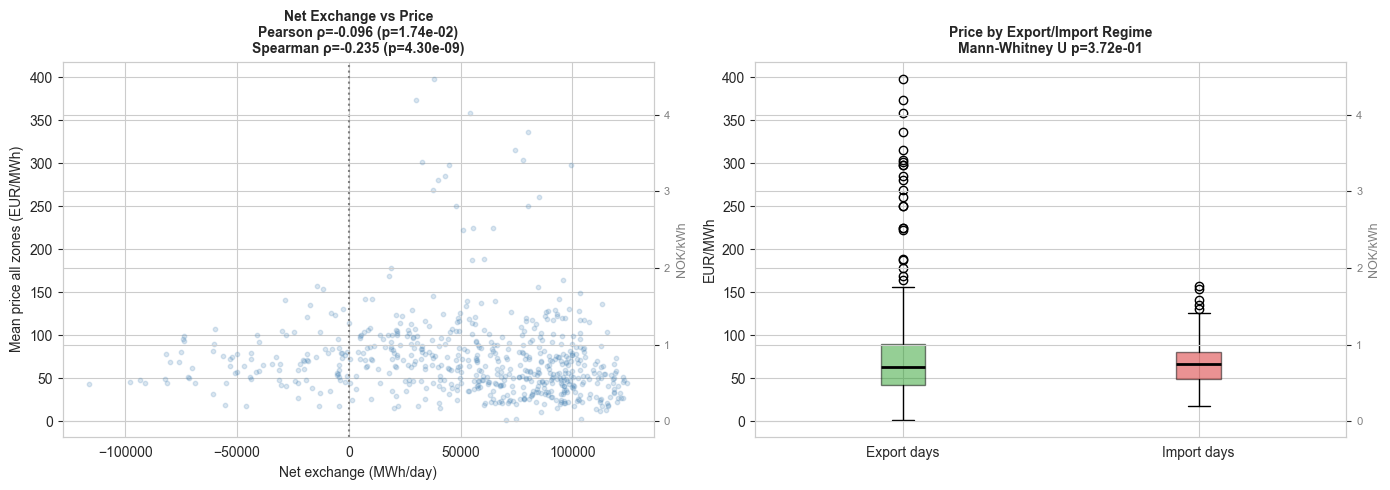

Export days: n=511, mean=73.83 EUR/MWh (0.828 NOK/kWh)
Import days: n=97, mean=69.83 EUR/MWh (0.783 NOK/kWh)
Mann-Whitney U test: U=23368, p=3.72e-01


In [16]:
# ── 4c: Export vs price correlation & regime analysis ────────────────

# Join aggregate daily price (mean of all zones) with flows
price_all = prices_d.mean(axis=1).rename("price_mean")
exp_price = pd.concat([fe["net_exchange_mwh"], price_all], axis=1).dropna()

rho_p, p_p = stats.pearsonr(exp_price["net_exchange_mwh"], exp_price["price_mean"])
rho_s, p_s = stats.spearmanr(exp_price["net_exchange_mwh"], exp_price["price_mean"])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter
ax = axes[0]
ax.scatter(exp_price["net_exchange_mwh"], exp_price["price_mean"], alpha=0.2, s=10, color="steelblue")
ax.axvline(0, color="gray", linestyle=":")
ax.set_xlabel("Net exchange (MWh/day)")
ax.set_ylabel("Mean price all zones (EUR/MWh)")
ax.set_title(f"Net Exchange vs Price\nPearson \u03c1={rho_p:.3f} (p={p_p:.2e})\nSpearman \u03c1={rho_s:.3f} (p={p_s:.2e})",
             fontweight="bold", fontsize=10)
add_nok_axis(ax)

# Regime analysis: split into export/import days
ax = axes[1]
export_days = exp_price[exp_price["net_exchange_mwh"] > 0]["price_mean"]
import_days = exp_price[exp_price["net_exchange_mwh"] <= 0]["price_mean"]

bp = ax.boxplot([export_days.values, import_days.values], labels=["Export days", "Import days"],
                patch_artist=True, medianprops={"color": "black", "linewidth": 2})
bp["boxes"][0].set_facecolor("tab:green")
bp["boxes"][0].set_alpha(0.5)
bp["boxes"][1].set_facecolor("tab:red")
bp["boxes"][1].set_alpha(0.5)

# Mann-Whitney U test
u_stat, u_p = stats.mannwhitneyu(export_days, import_days, alternative="two-sided")
ax.set_title(f"Price by Export/Import Regime\nMann-Whitney U p={u_p:.2e}", fontweight="bold", fontsize=10)
ax.set_ylabel("EUR/MWh")
add_nok_axis(ax)

plt.tight_layout()
plt.show()

print(f"Export days: n={len(export_days)}, mean={export_days.mean():.2f} EUR/MWh ({export_days.mean()*AVG_EUR_NOK/1000:.3f} NOK/kWh)")
print(f"Import days: n={len(import_days)}, mean={import_days.mean():.2f} EUR/MWh ({import_days.mean()*AVG_EUR_NOK/1000:.3f} NOK/kWh)")
print(f"Mann-Whitney U test: U={u_stat:.0f}, p={u_p:.2e}")
if u_p < 0.05:
    print("\u2192 Prices are significantly different between export and import days.")

---
## 5. Commodity Price Passthrough

European gas prices (TTF) are the primary external price driver for electricity.
This section quantifies the passthrough rate and tests whether the relationship
changed after the 2022 energy crisis.

### Methods used in this section

**Spearman correlation matrix** (cell 5a) — pairwise rank correlation across all zone prices, commodity close prices, and EUR/NOK FX rate. The heatmap shows which variables move together.

**Rolling correlation** (cell 5b) — Pearson ρ computed on a sliding 90-day window:

$$r_t = \text{Pearson}(X_{t-89:t}, \; Y_{t-89:t})$$

This reveals **time-varying** relationships. If correlation jumps during the energy crisis, it means the gas-electricity link strengthened. If it drops to zero later, the link weakened.

**Cross-correlation with lags** (cell 5c) — tests whether commodity price changes *lead* electricity prices by N days:

$$\rho(\tau) = \text{Corr}(X_t, \; Y_{t+\tau})$$

- τ > 0: commodity leads electricity (commodity moves first, electricity follows days later)
- τ = 0: contemporaneous (same-day) relationship
- τ < 0: electricity leads commodity (unlikely but possible)
- The **peak** of this function tells you the optimal lag for a predictive feature

### OLS Regression (Ordinary Least Squares) — cell 5d

Fits a linear model:

$$\text{Price}_z = \beta_0 + \beta_1 \cdot \text{TTF} + \beta_2 \cdot \text{Brent} + \beta_3 \cdot \text{Coal} + \beta_4 \cdot \text{NG} + \beta_5 \cdot \text{EUR/NOK} + \epsilon$$

Key outputs to read:
- **R²:** fraction of price variance explained by commodities + FX (0 to 1). Higher = more explained.
- **Adj R²:** R² penalized for number of predictors (fairer for model comparison)
- **F-statistic:** tests whether the overall model is significant (H₀: all β = 0)
- **Coefficients (β):** how much electricity price changes per unit change in each commodity
- **t-statistic:** coefficient / standard error — measures how many standard errors the coefficient is from zero
- **p-value per coefficient:** significance of each individual predictor
- Significance levels: \*\*\* p < 0.001, \*\* p < 0.01, \* p < 0.05

`statsmodels.api.OLS(y, X).fit()` — [docs](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html)

### Structural break analysis — cell 5e

Tests whether the gas-to-electricity relationship changed over time:
- **Rolling R²:** compute R² on sliding 90-day windows. A sudden drop/jump at a specific date indicates a **structural break** — the model's explanatory power changed.
- **Pre/post slope comparison:** fit separate regressions before and after the breakpoint. Different slopes = different passthrough rates. A steeper post-crisis slope means electricity became more sensitive to gas.

### What each cell below provides
- **5a:** Correlation heatmap (zones × commodities × FX) — which variables move together
- **5b:** TTF gas vs NO_1 price overlay + 90-day rolling correlation for all zones
- **5c:** Cross-correlation lag analysis — do commodity movements lead electricity prices?
- **5d:** Full OLS regression per zone with R², F-stat, and per-variable coefficients
- **5e:** Rolling R² over time + pre/post energy crisis slope comparison

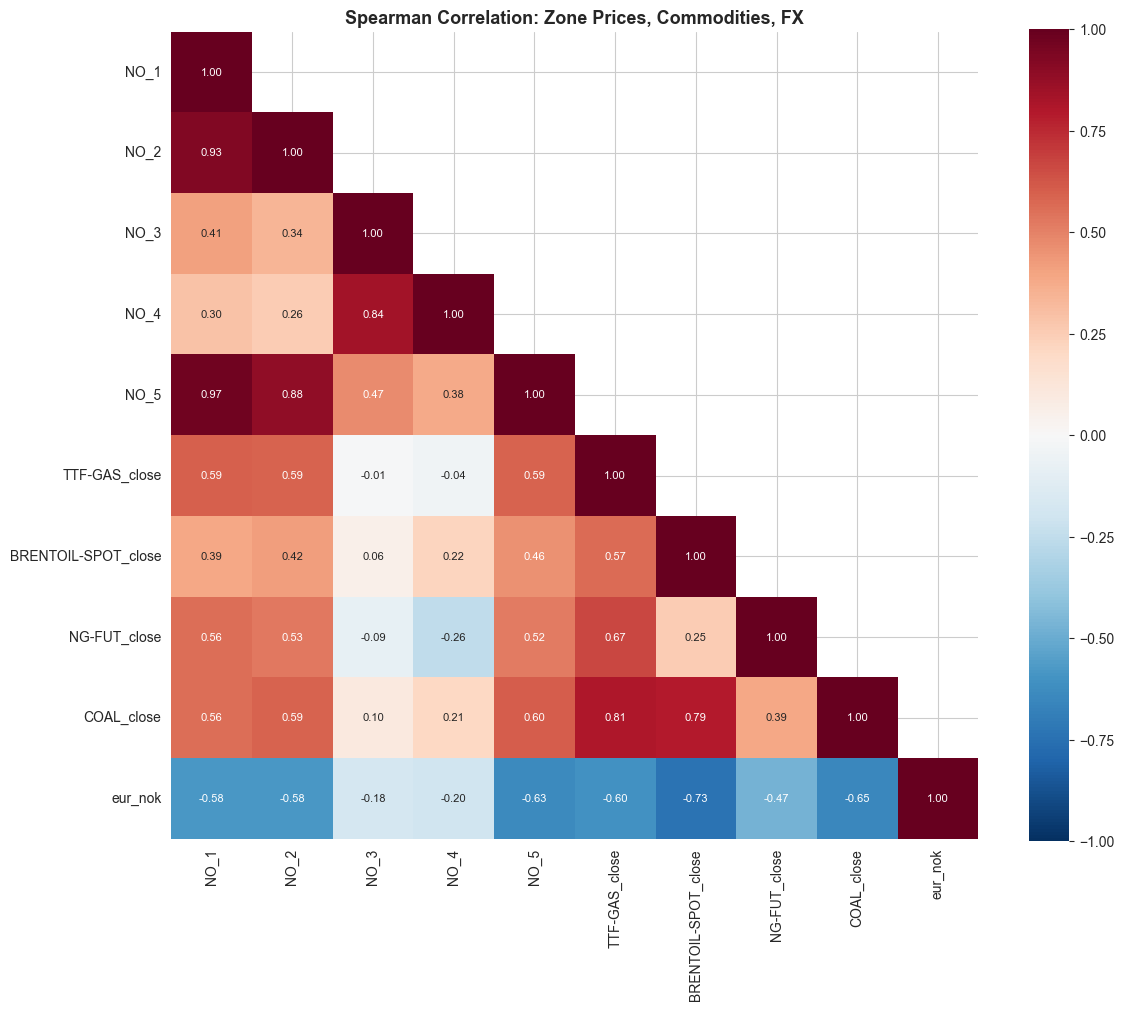

In [17]:
# ── 5a: Correlation matrix — commodities vs zone prices ──────────────

# Pick close prices for key commodities
comm_cols = [c for c in commodities.columns if c.endswith("_close")]
comm_clean = commodities[comm_cols].copy()
if comm_clean.index.tz is not None:
    comm_clean.index = comm_clean.index.tz_localize(None)

price_comm = prices_d.join(comm_clean, how="inner")
price_comm = price_comm.join(fx if fx.index.tz is None else fx.tz_localize(None), how="left")

corr_cols = ZONES + comm_cols
if "eur_nok" in price_comm.columns:
    corr_cols.append("eur_nok")

corr_matrix = price_comm[corr_cols].corr(method="spearman")

fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="RdBu_r",
            center=0, vmin=-1, vmax=1, square=True, ax=ax,
            annot_kws={"size": 8})
ax.set_title("Spearman Correlation: Zone Prices, Commodities, FX", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

Using commodity column: TTF-GAS_close


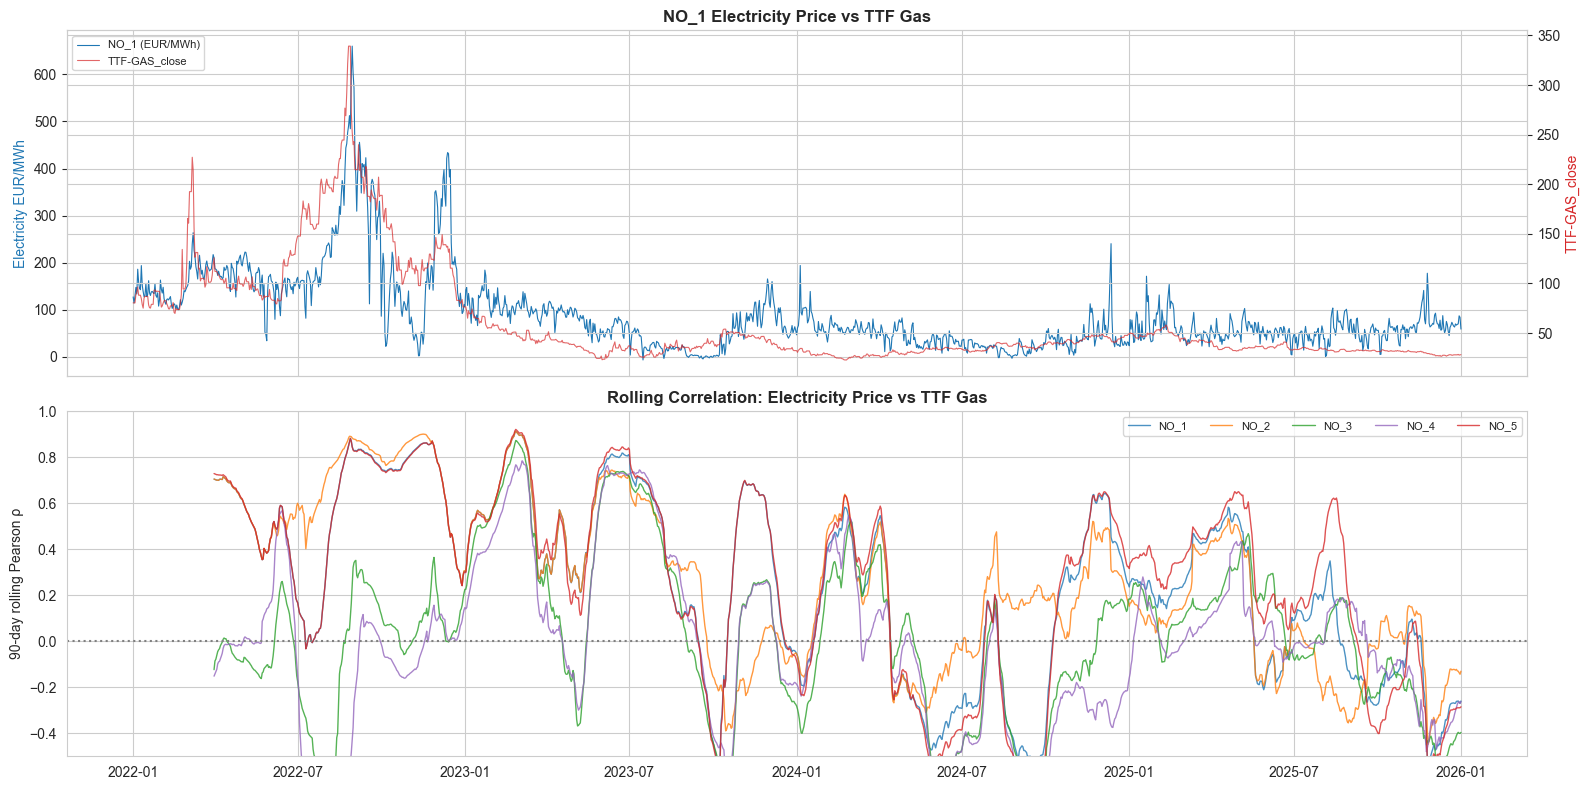

Correlation typically rises during high-gas-price periods (energy crisis) and falls during calm periods.


In [18]:
# ── 5b: Rolling 90-day correlation — TTF gas vs NO1 price ────────────

ttf_col = [c for c in comm_cols if "TTF" in c.upper() or "GAS" in c.upper()]
if not ttf_col:
    ttf_col = comm_cols[:1]  # fallback to first commodity
ttf_col = ttf_col[0]
print(f"Using commodity column: {ttf_col}")

fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

# Price comparison (dual axis)
ax = axes[0]
ax.plot(price_comm.index, price_comm["NO_1"], color="tab:blue", linewidth=0.8, label="NO_1 (EUR/MWh)")
ax2 = ax.twinx()
ax2.plot(price_comm.index, price_comm[ttf_col], color="tab:red", linewidth=0.8, alpha=0.7, label=ttf_col)
ax.set_ylabel("Electricity EUR/MWh", color="tab:blue")
ax2.set_ylabel(ttf_col, color="tab:red")
ax.set_title("NO_1 Electricity Price vs TTF Gas", fontweight="bold")
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc="upper left", fontsize=8)

# Rolling correlation
ax = axes[1]
for z in ZONES:
    roll_corr = price_comm[z].rolling(90).corr(price_comm[ttf_col])
    ax.plot(price_comm.index, roll_corr, color=ZONE_COLORS[z], linewidth=1, label=z, alpha=0.8)
ax.axhline(0, color="gray", linestyle=":")
ax.set_ylabel("90-day rolling Pearson ρ")
ax.set_title("Rolling Correlation: Electricity Price vs TTF Gas", fontweight="bold")
ax.legend(fontsize=8, ncol=5)
ax.set_ylim(-0.5, 1.0)

plt.tight_layout()
plt.show()
print("Correlation typically rises during high-gas-price periods (energy crisis) and falls during calm periods.")

CROSS-CORRELATION LAG ANALYSIS
Positive lag = commodity leads electricity price by N days

TTF-GAS_close:
  NO_1: peak correlation ρ=0.843 at lag=2 days
  NO_2: peak correlation ρ=0.873 at lag=1 days

BRENTOIL-SPOT_close:
  NO_1: peak correlation ρ=0.483 at lag=14 days
  NO_2: peak correlation ρ=0.518 at lag=14 days

NG-FUT_close:
  NO_1: peak correlation ρ=0.742 at lag=12 days
  NO_2: peak correlation ρ=0.750 at lag=7 days

COAL_close:
  NO_1: peak correlation ρ=0.749 at lag=1 days
  NO_2: peak correlation ρ=0.780 at lag=1 days


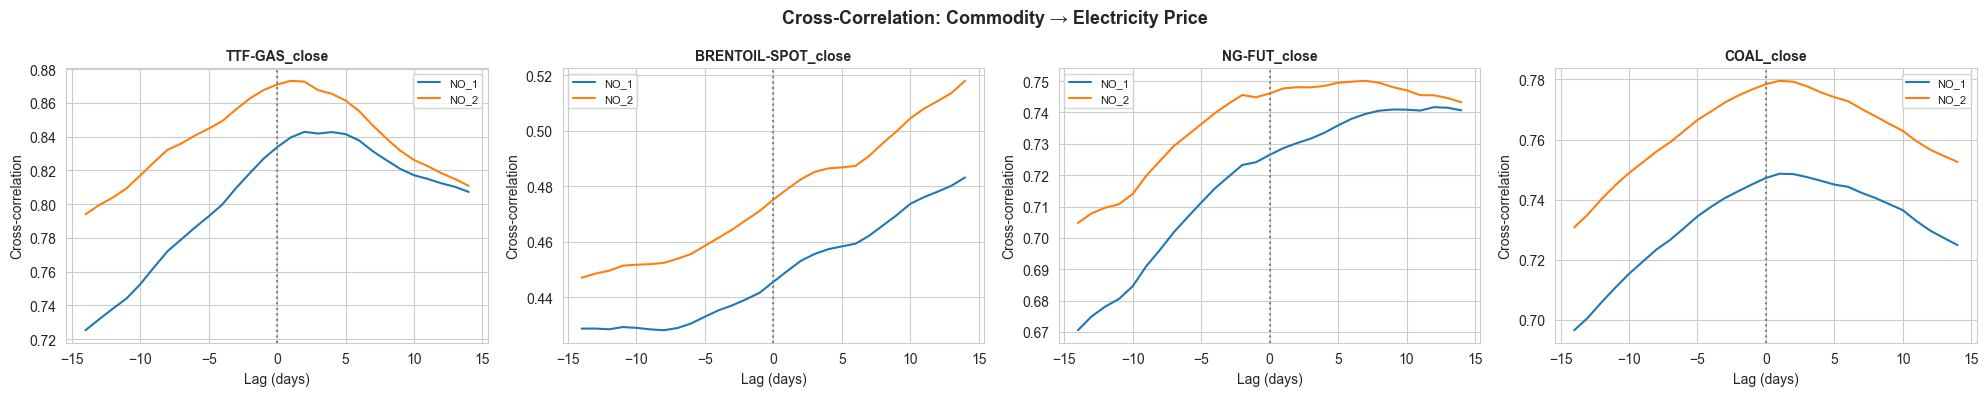

In [19]:
# ── 5c: Cross-correlation lag analysis — commodities lead prices? ────

print("CROSS-CORRELATION LAG ANALYSIS")
print("Positive lag = commodity leads electricity price by N days")
print("=" * 70)

max_lag = 14
fig, axes = plt.subplots(1, len(comm_cols), figsize=(5 * len(comm_cols), 4))
if len(comm_cols) == 1:
    axes = [axes]

for j, cc in enumerate(comm_cols):
    ax = axes[j]
    print(f"\n{cc}:")

    for z in ["NO_1", "NO_2"]:
        merged = price_comm[[z, cc]].dropna()
        if len(merged) < 30:
            continue

        x = (merged[cc] - merged[cc].mean()) / merged[cc].std()
        y = (merged[z] - merged[z].mean()) / merged[z].std()

        lag_corrs = []
        for lag in range(-max_lag, max_lag + 1):
            if lag > 0:
                c = np.corrcoef(x.iloc[:-lag], y.iloc[lag:])[0, 1]
            elif lag < 0:
                c = np.corrcoef(x.iloc[-lag:], y.iloc[:lag])[0, 1]
            else:
                c = np.corrcoef(x, y)[0, 1]
            lag_corrs.append(c)

        lags = list(range(-max_lag, max_lag + 1))
        ax.plot(lags, lag_corrs, label=z, color=ZONE_COLORS[z], linewidth=1.5)

        best_lag = lags[np.argmax(lag_corrs)]
        best_corr = max(lag_corrs)
        print(f"  {z}: peak correlation ρ={best_corr:.3f} at lag={best_lag} days")

    ax.axvline(0, color="gray", linestyle=":")
    ax.set_xlabel("Lag (days)")
    ax.set_ylabel("Cross-correlation")
    ax.set_title(cc, fontweight="bold", fontsize=10)
    ax.legend(fontsize=8)

plt.suptitle("Cross-Correlation: Commodity → Electricity Price", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

In [20]:
# ── 5d: OLS regression — price ~ TTF + Brent + coal + EUR/NOK ────────

print("OLS REGRESSION: Electricity price = f(commodities, FX)")
print("=" * 80)

regressors = [c for c in comm_cols]
if "eur_nok" in price_comm.columns:
    regressors.append("eur_nok")

ols_results = {}
for z in ZONES:
    data = price_comm[[z] + regressors].dropna()
    if len(data) < 30:
        print(f"  {z}: insufficient data")
        continue

    y = data[z]
    X = sm.add_constant(data[regressors])
    model = sm.OLS(y, X).fit()
    ols_results[z] = model

    print(f"\n{z} ({ZONE_LABELS[z]}):")
    print(f"  R² = {model.rsquared:.4f}, Adj R² = {model.rsquared_adj:.4f}")
    print(f"  F-stat = {model.fvalue:.2f}, p(F) = {model.f_pvalue:.2e}")
    print(f"  {'Variable':<25} {'Coef':>8} {'Std Err':>10} {'t':>8} {'p-value':>10}")
    for var in model.params.index:
        coef = model.params[var]
        se = model.bse[var]
        t = model.tvalues[var]
        p = model.pvalues[var]
        sig = "***" if p < 0.001 else ("**" if p < 0.01 else ("*" if p < 0.05 else ""))
        print(f"  {var:<25} {coef:>8.4f} {se:>10.4f} {t:>8.3f} {p:>10.2e} {sig}")

OLS REGRESSION: Electricity price = f(commodities, FX)

NO_1 (Oslo):
  R² = 0.7273, Adj R² = 0.7264
  F-stat = 776.66, p(F) = 0.00e+00
  Variable                      Coef    Std Err        t    p-value
  const                     548.1311    50.1588   10.928   8.99e-27 ***
  TTF-GAS_close               1.0467     0.0613   17.063   1.18e-59 ***
  BRENTOIL-SPOT_close        -2.0196     0.1826  -11.061   2.29e-27 ***
  NG-FUT_close                0.0419     1.3080    0.032   9.74e-01 
  COAL_close                  0.2045     0.0502    4.074   4.87e-05 ***
  eur_nok                   -34.6033     3.5958   -9.623   2.70e-21 ***

NO_2 (Kristiansand):
  R² = 0.7708, Adj R² = 0.7700
  F-stat = 979.06, p(F) = 0.00e+00
  Variable                      Coef    Std Err        t    p-value
  const                     256.1241    49.5881    5.165   2.74e-07 ***
  TTF-GAS_close               1.3624     0.0606   22.464   3.40e-96 ***
  BRENTOIL-SPOT_close        -1.5048     0.1805   -8.337   1.75e-16 

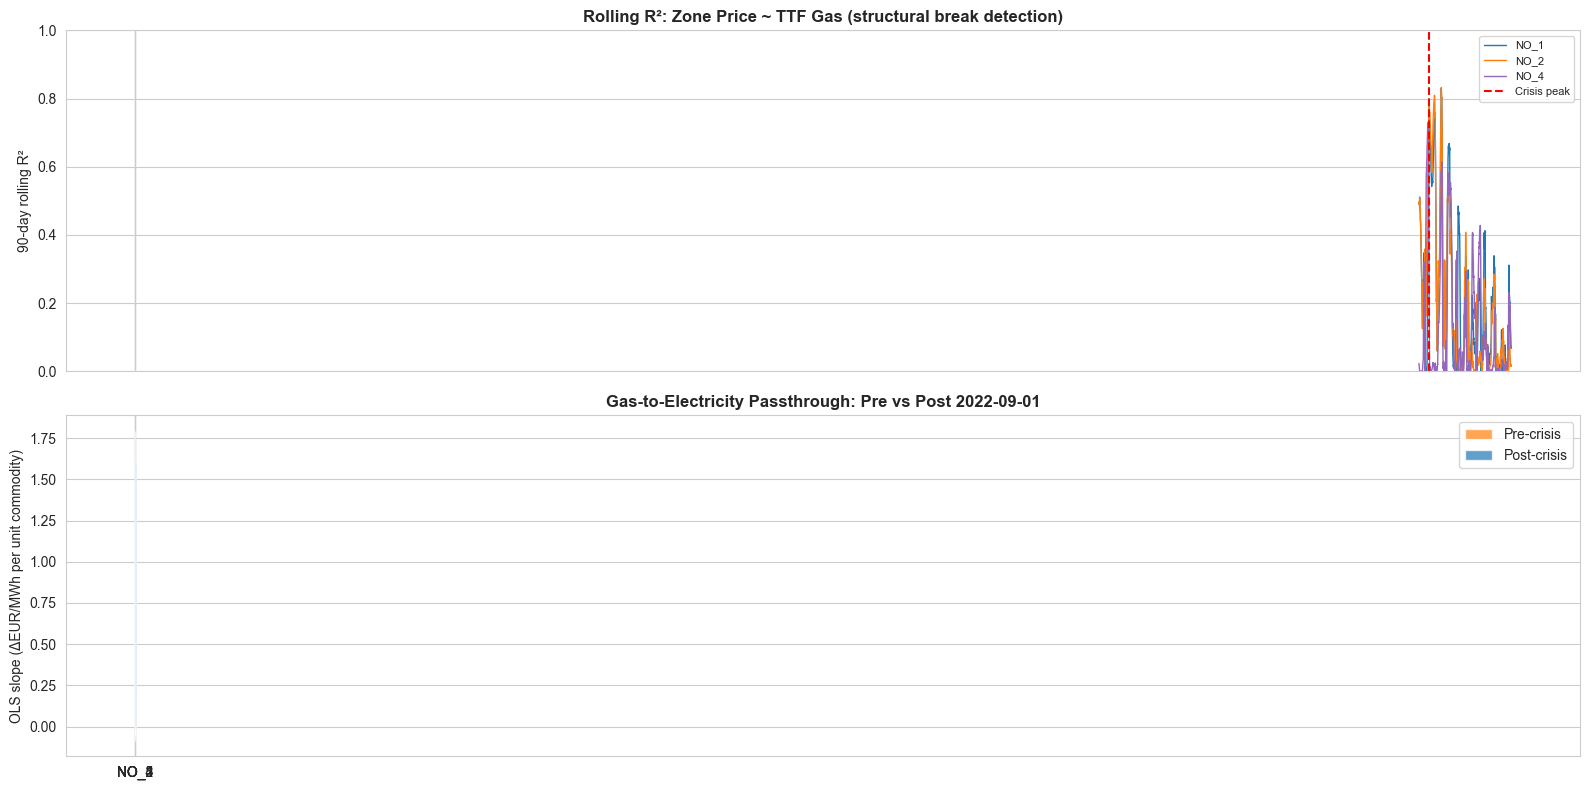


Passthrough coefficients (slope of price ~ TTF gas):
Zone  Pre-crisis slope  Post-crisis slope
NO_1          1.226477           1.562835
NO_2          1.795576           1.479407
NO_3         -0.055782           0.474608
NO_4         -0.085723           0.209265
NO_5          1.220571           1.594373

Higher post-crisis slope = electricity prices become more sensitive to gas after the crisis.


In [21]:
# ── 5e: Structural break — pre/post energy crisis ────────────────────

# Rolling regression R² to detect structural breaks
CRISIS_DATE = "2022-09-01"  # approximate peak of European energy crisis

fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

# Rolling 90-day R² for NO_1 ~ TTF gas
ax = axes[0]
for z in ["NO_1", "NO_2", "NO_4"]:
    data = price_comm[[z, ttf_col]].dropna()
    r2_series = pd.Series(index=data.index, dtype=float)
    for idx in range(90, len(data)):
        window = data.iloc[idx-90:idx]
        X_w = sm.add_constant(window[ttf_col])
        try:
            r2 = sm.OLS(window[z], X_w).fit().rsquared
            r2_series.iloc[idx] = r2
        except Exception:
            pass
    ax.plot(r2_series.index, r2_series.values, label=z, color=ZONE_COLORS[z], linewidth=1)

ax.axvline(pd.Timestamp(CRISIS_DATE), color="red", linestyle="--", label="Crisis peak")
ax.set_ylabel("90-day rolling R²")
ax.set_title("Rolling R²: Zone Price ~ TTF Gas (structural break detection)", fontweight="bold")
ax.legend(fontsize=8)
ax.set_ylim(0, 1)

# Pre vs post crisis regression coefficients
ax = axes[1]
pre = price_comm.loc[:CRISIS_DATE]
post = price_comm.loc[CRISIS_DATE:]

zone_coefs = {"Zone": [], "Pre-crisis slope": [], "Post-crisis slope": []}
for z in ZONES:
    for period, label in [(pre, "Pre-crisis slope"), (post, "Post-crisis slope")]:
        data = period[[z, ttf_col]].dropna()
        if len(data) > 10:
            slope, intercept, r, p, se = stats.linregress(data[ttf_col], data[z])
        else:
            slope = np.nan
        if label == "Pre-crisis slope":
            zone_coefs["Zone"].append(z)
            zone_coefs["Pre-crisis slope"].append(slope)
        else:
            zone_coefs["Post-crisis slope"].append(slope)

coef_df = pd.DataFrame(zone_coefs)
x = np.arange(len(ZONES))
ax.bar(x - 0.2, coef_df["Pre-crisis slope"], width=0.4, label="Pre-crisis", color="tab:orange", alpha=0.7)
ax.bar(x + 0.2, coef_df["Post-crisis slope"], width=0.4, label="Post-crisis", color="tab:blue", alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(ZONES)
ax.set_ylabel("OLS slope (ΔEUR/MWh per unit commodity)")
ax.set_title(f"Gas-to-Electricity Passthrough: Pre vs Post {CRISIS_DATE}", fontweight="bold")
ax.legend()

plt.tight_layout()
plt.show()

print("\nPassthrough coefficients (slope of price ~ TTF gas):")
print(coef_df.to_string(index=False))
print("\nHigher post-crisis slope = electricity prices become more sensitive to gas after the crisis.")

---
## 6. Zone Decoupling Analysis

Norwegian bidding zones can decouple when transmission constraints bind (cables between
zones reach capacity limits). When decoupled, zones set prices independently based on
local supply and demand. This section identifies when zones diverge and tests whether
price spreads are mean-reverting.

### Augmented Dickey-Fuller (ADF) Test

Tests whether a time series is **stationary** (constant mean and variance over time):

$$\Delta y_t = \alpha + \gamma y_{t-1} + \sum_{i=1}^{p} \delta_i \Delta y_{t-i} + \epsilon_t$$

and tests:
- H₀: γ = 0 → series has a **unit root** (non-stationary — wanders like a random walk)
- H₁: γ < 0 → series is **stationary** (mean-reverting — tends to return to its average)
- If p < 0.05 → reject H₀ → the series is stationary / mean-reverting

**Applied to price spreads:** If the spread between two zones (price_A − price_B) is stationary, it means the spread tends to **revert to its long-term mean**. Implications:
1. **Trading:** when spread deviates far from mean, it will likely come back → potential trading opportunity
2. **Modeling:** stationary spreads can be used as features in forecasting models
3. **Market structure:** stationary spreads suggest the two zones are fundamentally connected (transmission usually flows to equalize prices)

`statsmodels.tsa.stattools.adfuller(data, autolag='AIC')` — [docs](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html)

### What each cell below provides
- **6a:** Inter-zone Pearson correlation matrix — which zone pairs move together most/least
- **6b:** Rolling 30-day correlation — identifies periods where zones decouple (ρ drops below 0.5)
- **6c:** Price spread time series per zone pair + ADF stationarity test (is the spread mean-reverting?)
- **6d:** North-South structural divide — (NO1+NO2)/2 vs (NO3+NO4)/2 with ADF test, KDE, and skewness

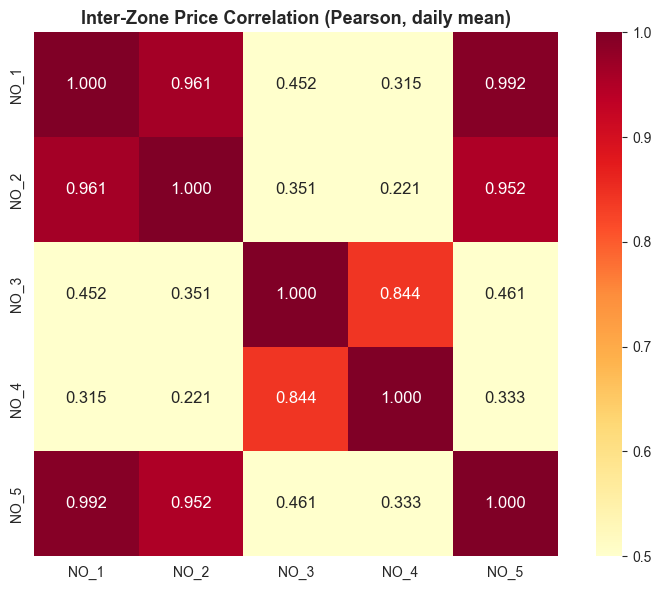

Zone pairs ranked by correlation:
  NO_1–NO_5: ρ=0.9923
  NO_1–NO_2: ρ=0.9610
  NO_2–NO_5: ρ=0.9523
  NO_3–NO_4: ρ=0.8437
  NO_3–NO_5: ρ=0.4610
  NO_1–NO_3: ρ=0.4517
  NO_2–NO_3: ρ=0.3512
  NO_4–NO_5: ρ=0.3335
  NO_1–NO_4: ρ=0.3155
  NO_2–NO_4: ρ=0.2210


In [22]:
# ── 6a: Inter-zone correlation matrix ────────────────────────────────

zone_corr = prices_d[ZONES].corr(method="pearson")

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(zone_corr, annot=True, fmt=".3f", cmap="YlOrRd", vmin=0.5, vmax=1,
            square=True, ax=ax, annot_kws={"size": 12})
ax.set_title("Inter-Zone Price Correlation (Pearson, daily mean)", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

# Most/least correlated pairs
pairs = []
for i, z1 in enumerate(ZONES):
    for j, z2 in enumerate(ZONES):
        if i < j:
            pairs.append((z1, z2, zone_corr.loc[z1, z2]))
pairs.sort(key=lambda x: x[2], reverse=True)
print("Zone pairs ranked by correlation:")
for z1, z2, c in pairs:
    print(f"  {z1}–{z2}: ρ={c:.4f}")

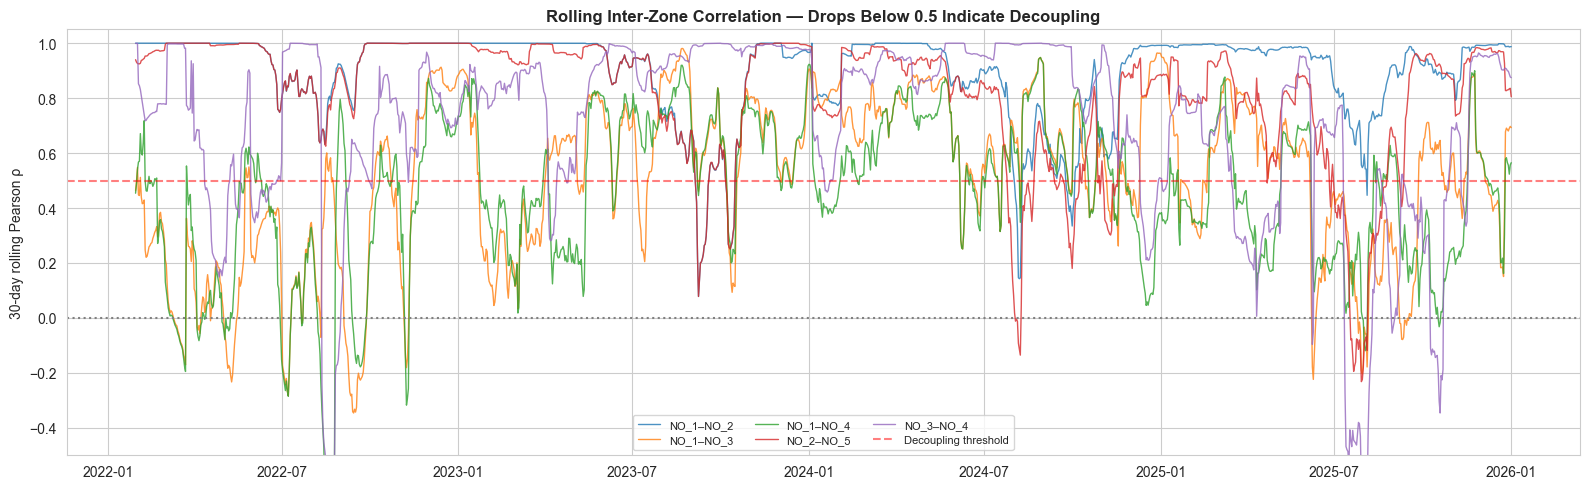

In [23]:
# ── 6b: Rolling 30-day correlation — detect decoupling periods ───────

key_pairs = [("NO_1", "NO_2"), ("NO_1", "NO_3"), ("NO_1", "NO_4"),
             ("NO_2", "NO_5"), ("NO_3", "NO_4")]

fig, ax = plt.subplots(figsize=(16, 5))

for z1, z2 in key_pairs:
    roll = prices_d[z1].rolling(30).corr(prices_d[z2])
    ax.plot(roll.index, roll.values, linewidth=1, label=f"{z1}–{z2}", alpha=0.8)

ax.axhline(0.5, color="red", linestyle="--", alpha=0.5, label="Decoupling threshold")
ax.axhline(0, color="gray", linestyle=":")
ax.set_ylabel("30-day rolling Pearson ρ")
ax.set_title("Rolling Inter-Zone Correlation — Drops Below 0.5 Indicate Decoupling", fontweight="bold")
ax.legend(fontsize=8, ncol=3)
ax.set_ylim(-0.5, 1.05)

plt.tight_layout()
plt.show()

PRICE SPREAD STATIONARITY (ADF test)
H0: spread has a unit root (non-stationary). Reject → spread is mean-reverting.
------------------------------------------------------------------------------------------
Pair           ADF stat    p-value   Mean EUR   Mean NOK/kWh      Std  Stationary?
------------------------------------------------------------------------------------------
  NO_1–NO_2       -3.1778     0.0213     -11.59        -0.1300    25.25          Yes
  NO_1–NO_3       -2.6700     0.0794      57.46         0.6447    75.03           No
  NO_1–NO_4       -3.0877     0.0275      68.30         0.7662    79.80          Yes
  NO_2–NO_5       -3.4346     0.0098      14.78         0.1658    27.70          Yes
  NO_3–NO_4       -5.8417     0.0000      10.83         0.1215    22.09          Yes
  NO_1–NO_5       -4.2516     0.0005       3.19         0.0358    10.51          Yes


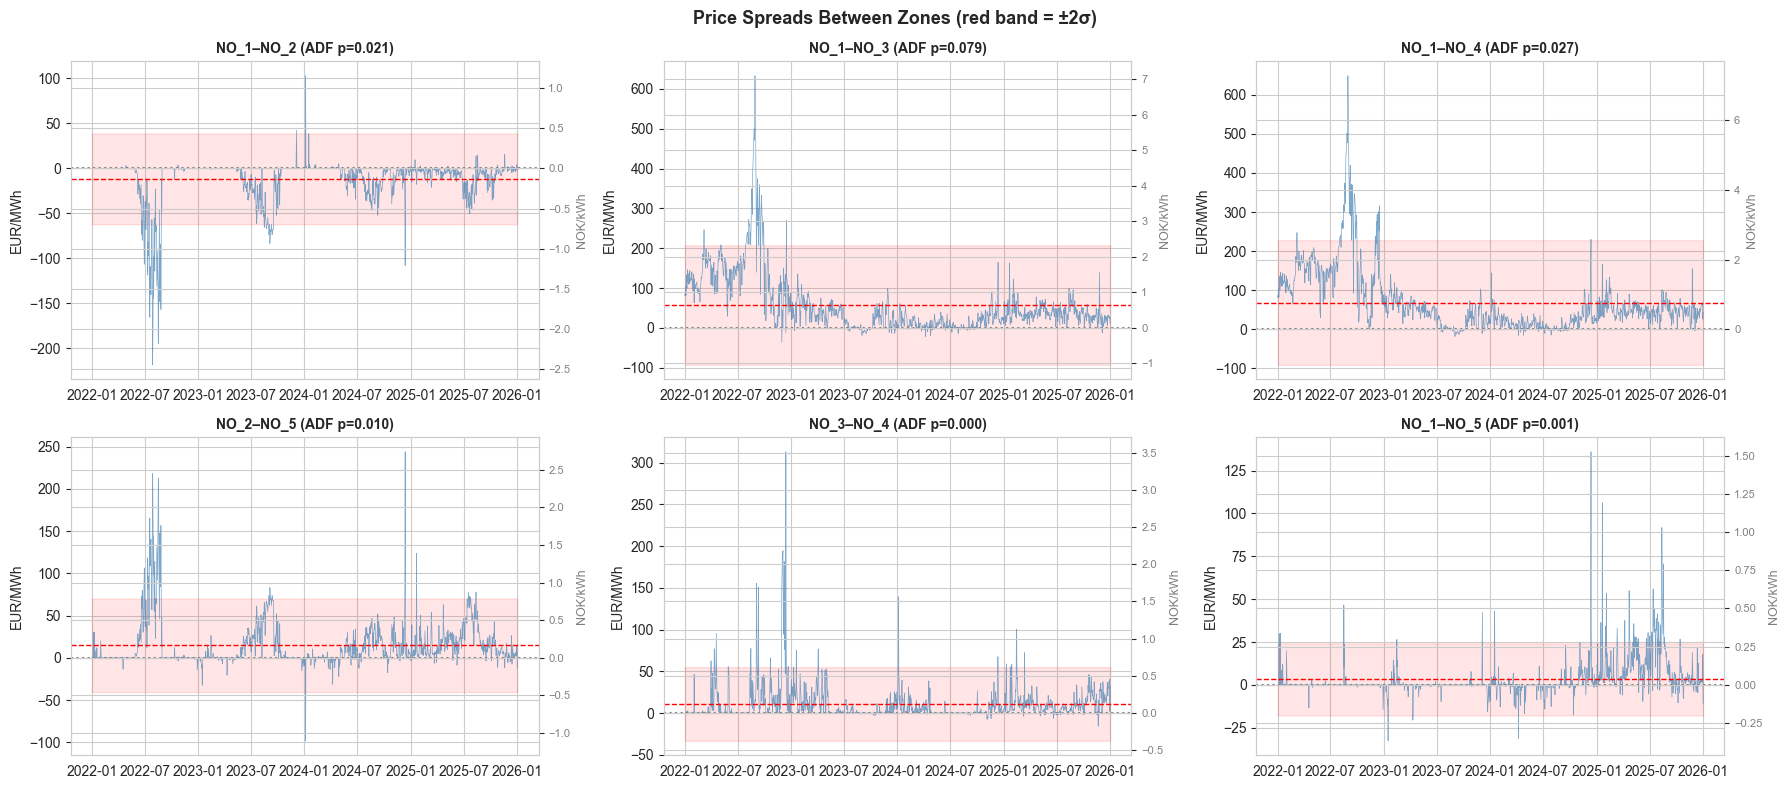


Stationary spreads are mean-reverting → trading opportunity when spread deviates.
(Right y-axis shows NOK/kWh at avg EUR/NOK = 11.22)


In [24]:
# ── 6c: Price spread analysis with ADF stationarity test ─────────────

spread_pairs = [("NO_1", "NO_2"), ("NO_1", "NO_3"), ("NO_1", "NO_4"),
                ("NO_2", "NO_5"), ("NO_3", "NO_4"), ("NO_1", "NO_5")]

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

print("PRICE SPREAD STATIONARITY (ADF test)")
print("H0: spread has a unit root (non-stationary). Reject \u2192 spread is mean-reverting.")
print("-" * 90)
print(f"{'Pair':<12} {'ADF stat':>10} {'p-value':>10} {'Mean EUR':>10} {'Mean NOK/kWh':>14} {'Std':>8} {'Stationary?':>12}")
print("-" * 90)

for i, (z1, z2) in enumerate(spread_pairs):
    spread = (prices_d[z1] - prices_d[z2]).dropna()

    # ADF test
    adf_stat, adf_p, _, _, critical, _ = adfuller(spread, autolag="AIC")
    stationary = "Yes" if adf_p < 0.05 else "No"
    mean_nok = spread.mean() * AVG_EUR_NOK / 1000
    print(f"  {z1}\u2013{z2}    {adf_stat:>10.4f} {adf_p:>10.4f} {spread.mean():>10.2f} {mean_nok:>14.4f} {spread.std():>8.2f} {stationary:>12}")

    # Plot
    ax = axes[i]
    ax.plot(spread.index, spread.values, linewidth=0.5, color="steelblue", alpha=0.7)
    ax.axhline(spread.mean(), color="red", linestyle="--", linewidth=1)
    ax.axhline(0, color="gray", linestyle=":")
    ax.fill_between(spread.index, spread.mean() - 2*spread.std(), spread.mean() + 2*spread.std(),
                    alpha=0.1, color="red")
    ax.set_title(f"{z1}\u2013{z2} (ADF p={adf_p:.3f})", fontsize=10, fontweight="bold")
    ax.set_ylabel("EUR/MWh")
    add_nok_axis(ax)

fig.suptitle("Price Spreads Between Zones (red band = \u00b12\u03c3)", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

print("\nStationary spreads are mean-reverting \u2192 trading opportunity when spread deviates.")
print(f"(Right y-axis shows NOK/kWh at avg EUR/NOK = {AVG_EUR_NOK:.2f})")

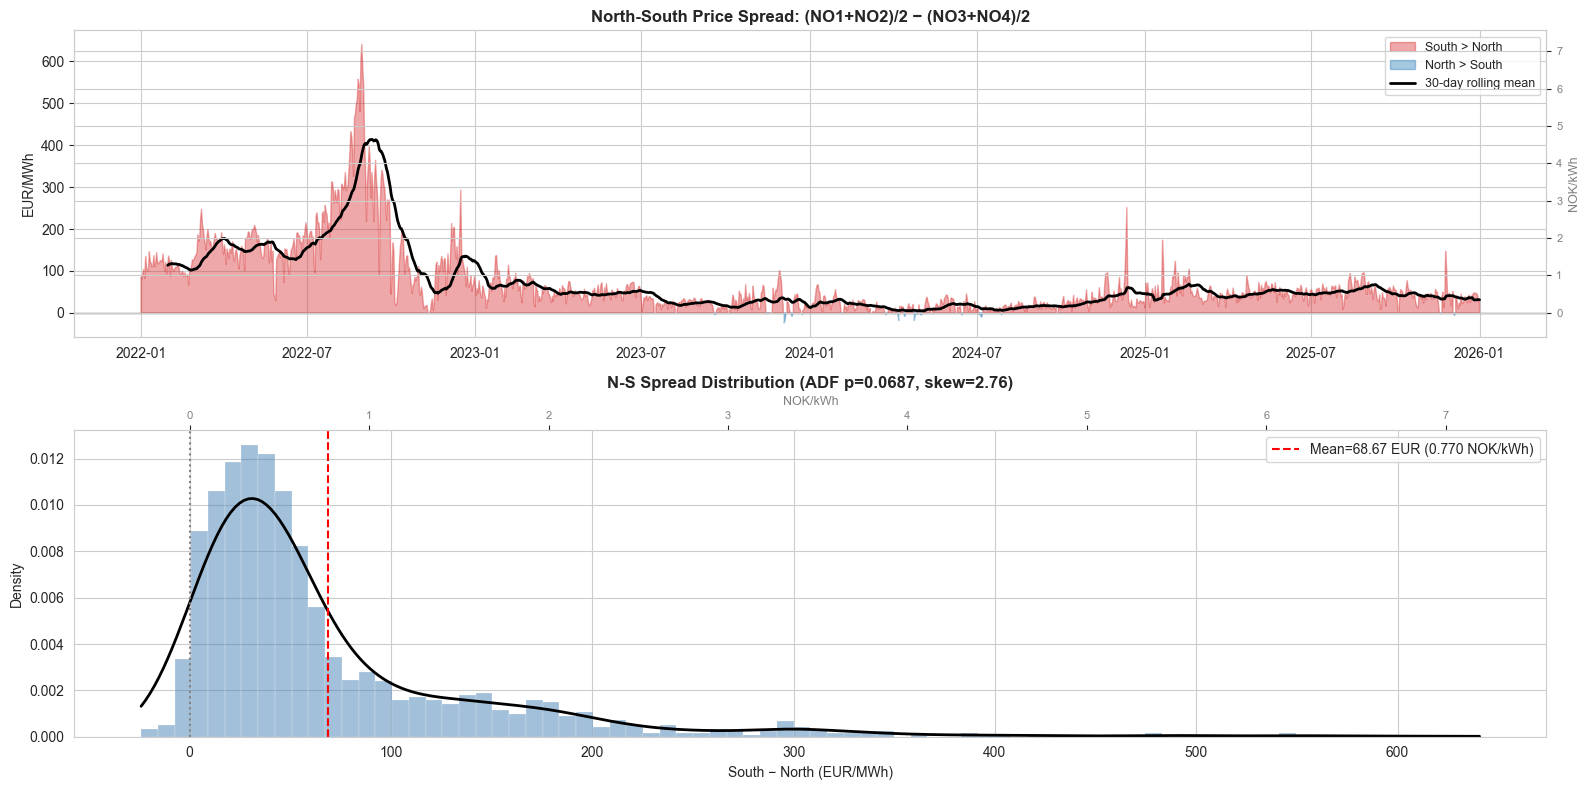

South higher than North: 96.9% of days
Mean spread: 68.67 EUR/MWh (0.770 NOK/kWh)
ADF test: stat=-2.7319, p=0.0687 → Non-stationary


In [25]:
# ── 6d: North-South divide — structural analysis ─────────────────────

north = prices_d[["NO_3", "NO_4"]].mean(axis=1)
south = prices_d[["NO_1", "NO_2"]].mean(axis=1)
ns_spread = south - north
ns_spread = ns_spread.dropna()

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Time series
ax = axes[0]
ax.fill_between(ns_spread.index, 0, ns_spread.values,
                where=ns_spread > 0, color="tab:red", alpha=0.4, label="South > North")
ax.fill_between(ns_spread.index, 0, ns_spread.values,
                where=ns_spread <= 0, color="tab:blue", alpha=0.4, label="North > South")
roll = ns_spread.rolling(30).mean()
ax.plot(roll.index, roll.values, color="black", linewidth=2, label="30-day rolling mean")
ax.axhline(0, color="gray", linewidth=1)
ax.set_ylabel("EUR/MWh")
ax.set_title("North-South Price Spread: (NO1+NO2)/2 \u2212 (NO3+NO4)/2", fontweight="bold")
ax.legend(fontsize=9)
add_nok_axis(ax)

# Distribution
ax = axes[1]
ax.hist(ns_spread, bins=80, density=True, alpha=0.5, color="steelblue", edgecolor="white", linewidth=0.3)
kde = stats.gaussian_kde(ns_spread)
x_kde = np.linspace(ns_spread.min(), ns_spread.max(), 300)
ax.plot(x_kde, kde(x_kde), color="black", linewidth=2)
ax.axvline(0, color="gray", linestyle=":")
ax.axvline(ns_spread.mean(), color="red", linestyle="--",
           label=f"Mean={ns_spread.mean():.2f} EUR ({ns_spread.mean()*AVG_EUR_NOK/1000:.3f} NOK/kWh)")
ax.set_xlabel("South \u2212 North (EUR/MWh)")
ax.set_ylabel("Density")

# Secondary x-axis for NOK/kWh
ax2 = ax.secondary_xaxis("top", functions=(
    lambda x: x * AVG_EUR_NOK / 1000,
    lambda x: x * 1000 / AVG_EUR_NOK
))
ax2.set_xlabel("NOK/kWh", fontsize=9, color="gray")
ax2.tick_params(labelsize=8, labelcolor="gray")

# ADF on N-S spread
adf_stat, adf_p, *_ = adfuller(ns_spread, autolag="AIC")
ax.set_title(f"N-S Spread Distribution (ADF p={adf_p:.4f}, skew={stats.skew(ns_spread):.2f})", fontweight="bold")
ax.legend()

pct_south_higher = (ns_spread > 0).mean() * 100

plt.tight_layout()
plt.show()

print(f"South higher than North: {pct_south_higher:.1f}% of days")
print(f"Mean spread: {ns_spread.mean():.2f} EUR/MWh ({ns_spread.mean()*AVG_EUR_NOK/1000:.3f} NOK/kWh)")
print(f"ADF test: stat={adf_stat:.4f}, p={adf_p:.4f} \u2192 {'Stationary (mean-reverting)' if adf_p < 0.05 else 'Non-stationary'}")

---
## 7. Autocorrelation & Stationarity

Understanding the **lag structure** of prices is critical for feature engineering.
Which past hours help predict the current hour? Are prices stationary?

### ADF vs KPSS — Two Complementary Stationarity Tests

| Test | H₀ (null hypothesis) | Reject means... |
|------|---------------------|-----------------|
| **ADF** | Series has a unit root (non-stationary) | Series IS stationary |
| **KPSS** | Series IS stationary | Series is NOT stationary |

Using both gives four possible outcomes:

| ADF result | KPSS result | Conclusion |
|---|---|---|
| Reject (p < 0.05) | Fail to reject (p > 0.05) | **Stationary** (both agree) |
| Fail to reject | Reject | **Non-stationary** (both agree) |
| Reject | Reject | Trend-stationary (stationary around a deterministic trend) |
| Fail to reject | Fail to reject | Inconclusive |

`statsmodels.tsa.stattools.kpss(data, regression='c', nlags='auto')` — [docs](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.kpss.html)

### Differencing — Making Non-Stationary Series Stationary

- **1st difference:** $\Delta y_t = y_t - y_{t-1}$ — removes trends
- **Seasonal difference (24h):** $\Delta_{24} y_t = y_t - y_{t-24}$ — removes daily cycle patterns
- If raw prices are non-stationary but differenced prices are stationary → the differenced version is better for modeling

### ACF (Autocorrelation Function)

Correlation of the series with itself at lag k:

$$\rho_k = \frac{\text{Cov}(Y_t, Y_{t-k})}{\text{Var}(Y_t)} = \frac{\sum_{t=k+1}^{n}(y_t - \bar{y})(y_{t-k} - \bar{y})}{\sum_{t=1}^{n}(y_t - \bar{y})^2}$$

- ACF at lag 24 = how correlated today's 3pm price is with yesterday's 3pm price
- ACF at lag 168 = correlation with same hour last week
- High ACF at a lag → that lag is useful as a predictive feature

`statsmodels.tsa.stattools.acf(data, nlags=168, fft=True)` — [docs](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acf.html)

### PACF (Partial Autocorrelation Function)

Correlation at lag k **after removing the effects of all shorter lags**:

- ACF at lag 48 might be high just because lag 24 is high (24 × 2 = 48, inherited correlation)
- PACF at lag 48 tells you whether lag 48 has **direct** predictive power beyond what lag 24 already provides
- Significant PACF spikes → those specific lags should be features in your model
- Example: if PACF is significant at lags 1, 24, and 168 → use price_lag_1h, price_lag_24h, price_lag_168h

`statsmodels.tsa.stattools.pacf(data, nlags=168, method='ywm')` — [docs](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf.html)

`statsmodels.graphics.tsaplots.plot_acf / plot_pacf` — convenience functions that draw ACF/PACF bar plots with confidence bands. Points **outside the shaded band** are statistically significant.

### What each cell below provides
- **7a:** ADF + KPSS stationarity tests on raw hourly prices, 1st-differenced, and 24h-seasonally-differenced per zone
- **7b:** ACF/PACF plots for NO_1 (south) vs NO_4 (north) — raw and 24h-differenced, up to 168h (1 week)
- **7c:** Top 10 ACF lags per zone — confirms dominant lags at 24h multiples

In [26]:
# ── 7a: ADF & KPSS stationarity tests ───────────────────────────────

print("STATIONARITY TESTS ON HOURLY PRICES")
print("ADF: H0 = unit root (non-stationary). KPSS: H0 = stationary.")
print("Best case: ADF rejects + KPSS fails to reject → stationary.")
print("=" * 80)

prices_tz_naive = prices_h.copy()
if prices_tz_naive.index.tz is not None:
    prices_tz_naive.index = prices_tz_naive.index.tz_localize(None)

results_rows = []
for z in ZONES:
    s = prices_tz_naive[z].dropna()

    # Raw prices
    adf_stat, adf_p, *_ = adfuller(s, maxlag=168, autolag="AIC")
    kpss_stat, kpss_p, *_ = kpss(s, regression="c", nlags="auto")
    results_rows.append({"Zone": z, "Series": "Raw",
                         "ADF stat": f"{adf_stat:.4f}", "ADF p": f"{adf_p:.4f}",
                         "KPSS stat": f"{kpss_stat:.4f}", "KPSS p": f"{kpss_p:.4f}",
                         "Conclusion": "Stationary" if (adf_p < 0.05 and kpss_p > 0.05) else "Non-stationary"})

    # 1st difference
    s_diff = s.diff().dropna()
    adf_stat, adf_p, *_ = adfuller(s_diff, maxlag=168, autolag="AIC")
    kpss_stat, kpss_p, *_ = kpss(s_diff, regression="c", nlags="auto")
    results_rows.append({"Zone": z, "Series": "1st diff",
                         "ADF stat": f"{adf_stat:.4f}", "ADF p": f"{adf_p:.4f}",
                         "KPSS stat": f"{kpss_stat:.4f}", "KPSS p": f"{kpss_p:.4f}",
                         "Conclusion": "Stationary" if (adf_p < 0.05 and kpss_p > 0.05) else "Check"})

    # Seasonal difference (24h)
    s_sdiff = (s - s.shift(24)).dropna()
    adf_stat, adf_p, *_ = adfuller(s_sdiff, maxlag=168, autolag="AIC")
    kpss_stat, kpss_p, *_ = kpss(s_sdiff, regression="c", nlags="auto")
    results_rows.append({"Zone": z, "Series": "24h seasonal diff",
                         "ADF stat": f"{adf_stat:.4f}", "ADF p": f"{adf_p:.4f}",
                         "KPSS stat": f"{kpss_stat:.4f}", "KPSS p": f"{kpss_p:.4f}",
                         "Conclusion": "Stationary" if (adf_p < 0.05 and kpss_p > 0.05) else "Check"})

stationarity_df = pd.DataFrame(results_rows)
print(stationarity_df.to_string(index=False))

STATIONARITY TESTS ON HOURLY PRICES
ADF: H0 = unit root (non-stationary). KPSS: H0 = stationary.
Best case: ADF rejects + KPSS fails to reject → stationary.


/var/folders/_2/_llw2n8s67n_9kq4z4d57vvr0000gn/T/ipykernel_22266/158180252.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(s, regression="c", nlags="auto")
/var/folders/_2/_llw2n8s67n_9kq4z4d57vvr0000gn/T/ipykernel_22266/158180252.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(s_diff, regression="c", nlags="auto")
/var/folders/_2/_llw2n8s67n_9kq4z4d57vvr0000gn/T/ipykernel_22266/158180252.py:36: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(s_sdiff, regression="c", nlags="auto")
/var/folders/_2/_llw2n8s67n_9kq4z4d57vvr0000gn/T/i

Zone            Series ADF stat  ADF p KPSS stat KPSS p     Conclusion
NO_1               Raw  -3.1259 0.0247   12.0855 0.0100 Non-stationary
NO_1          1st diff -19.4650 0.0000    0.0173 0.1000     Stationary
NO_1 24h seasonal diff -15.6459 0.0000    0.0095 0.1000     Stationary
NO_2               Raw  -2.9183 0.0433   12.0052 0.0100 Non-stationary
NO_2          1st diff -20.4121 0.0000    0.0562 0.1000     Stationary
NO_2 24h seasonal diff -15.9951 0.0000    0.0092 0.1000     Stationary
NO_3               Raw  -5.8434 0.0000    2.2977 0.0100 Non-stationary
NO_3          1st diff -20.3017 0.0000    0.0065 0.1000     Stationary
NO_3 24h seasonal diff -18.1457 0.0000    0.0044 0.1000     Stationary
NO_4               Raw  -6.2737 0.0000    3.3971 0.0100 Non-stationary
NO_4          1st diff -20.1286 0.0000    0.0051 0.1000     Stationary
NO_4 24h seasonal diff -20.4283 0.0000    0.0037 0.1000     Stationary
NO_5               Raw  -2.9947 0.0354   13.2998 0.0100 Non-stationary
NO_5  

/var/folders/_2/_llw2n8s67n_9kq4z4d57vvr0000gn/T/ipykernel_22266/158180252.py:36: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(s_sdiff, regression="c", nlags="auto")


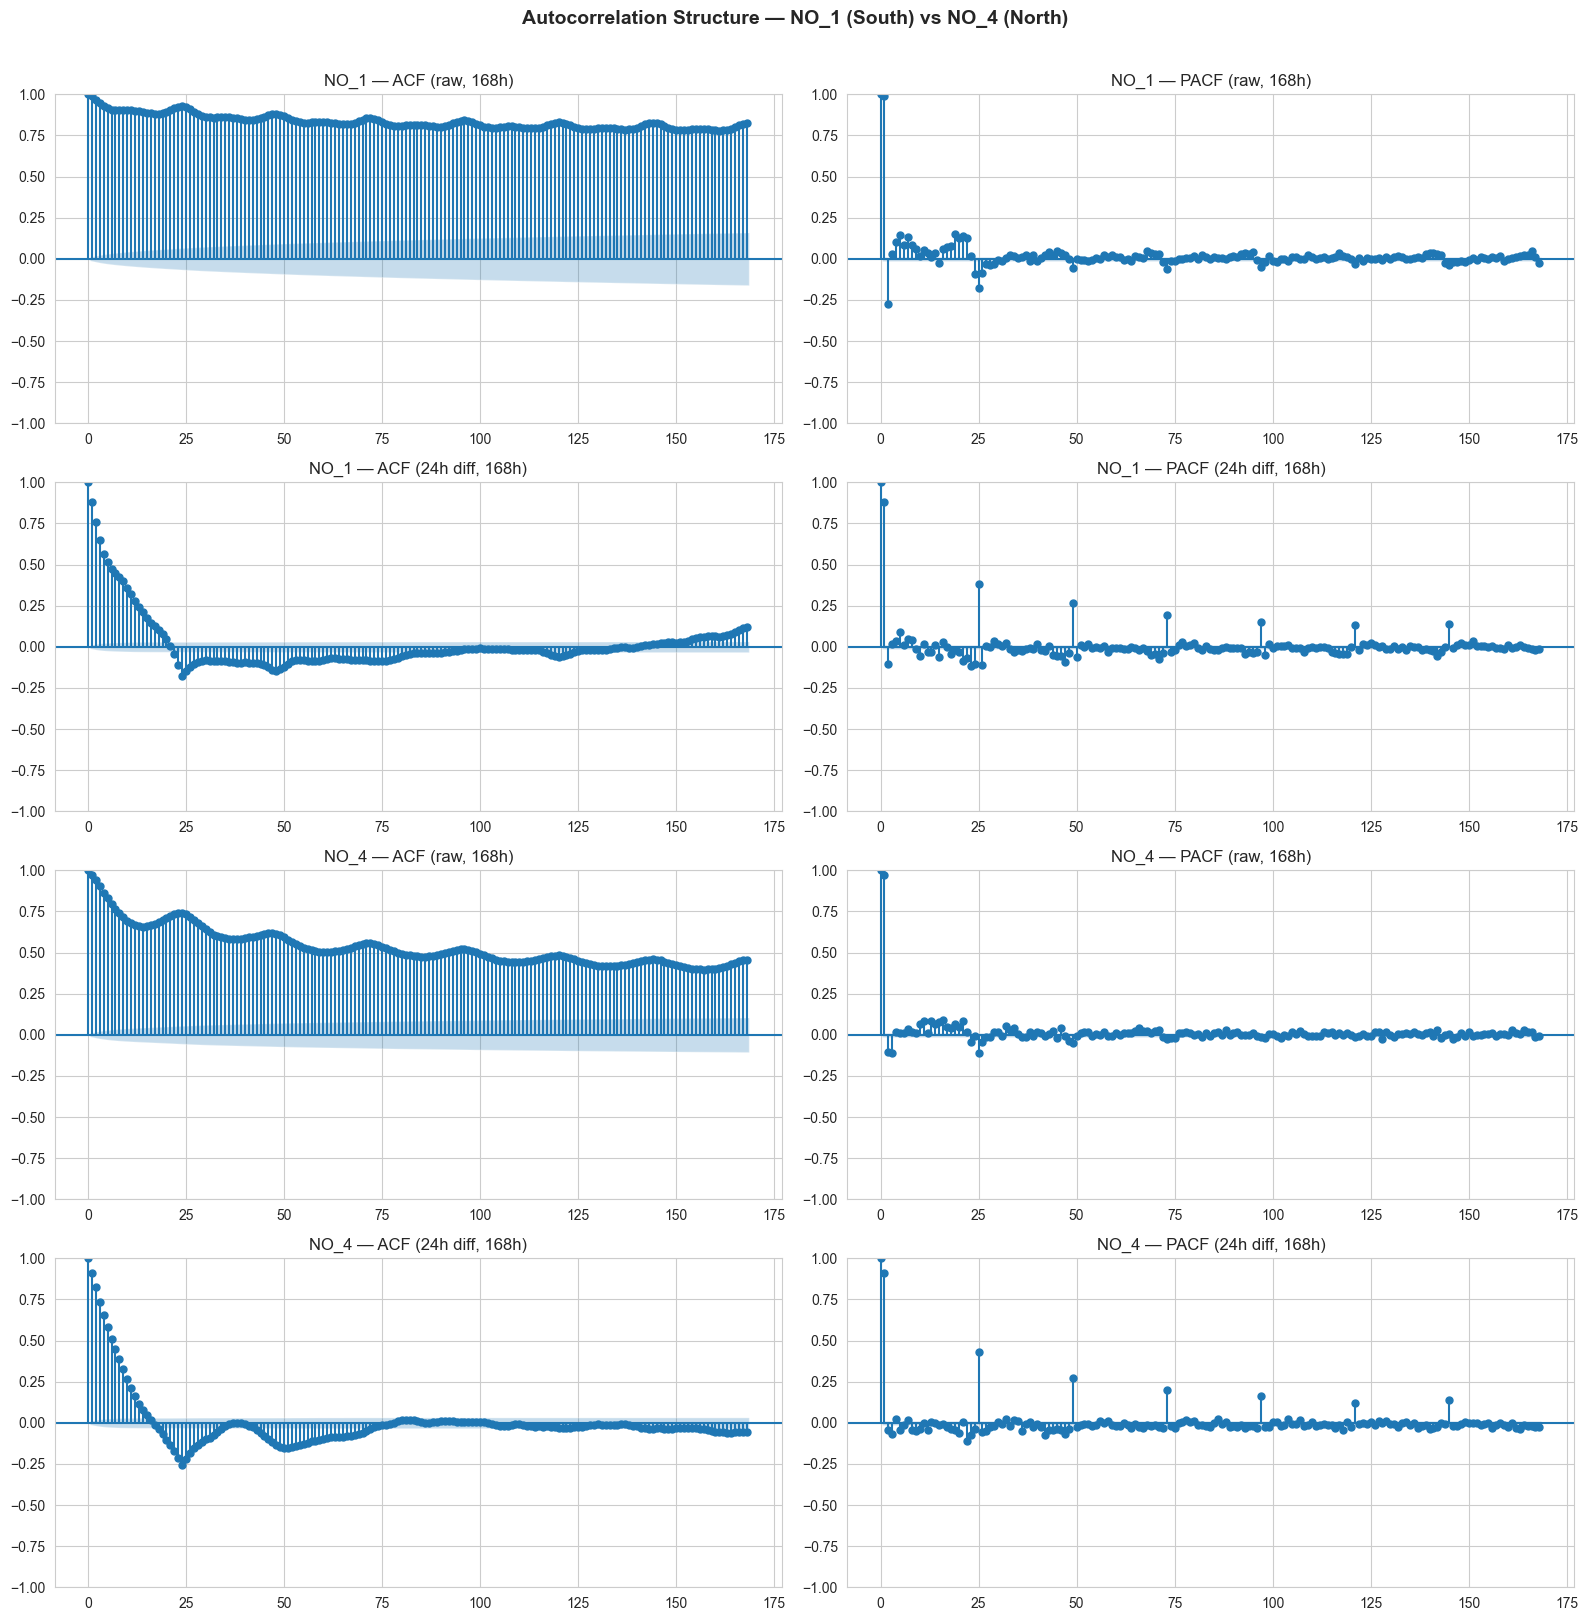

Key observations:
- Raw ACF shows strong 24h and 168h (weekly) periodicity
- PACF reveals which specific lags have direct predictive power
- After 24h differencing, weekly lag (168h) should still be visible
- These lags directly inform feature engineering: price_lag_1h, 24h, 168h


In [27]:
# ── 7b: ACF/PACF plots for key zones ─────────────────────────────────

fig, axes = plt.subplots(4, 2, figsize=(16, 16))

for i, z in enumerate(["NO_1", "NO_4"]):  # South vs North representative
    s = prices_tz_naive[z].dropna()

    # ACF raw
    plot_acf(s, lags=168, ax=axes[i*2, 0], title=f"{z} — ACF (raw, 168h)", alpha=0.05)

    # PACF raw
    plot_pacf(s, lags=168, ax=axes[i*2, 1], title=f"{z} — PACF (raw, 168h)", alpha=0.05, method="ywm")

    # ACF 24h differenced
    s_diff = (s - s.shift(24)).dropna()
    plot_acf(s_diff, lags=168, ax=axes[i*2+1, 0], title=f"{z} — ACF (24h diff, 168h)", alpha=0.05)

    # PACF 24h differenced
    plot_pacf(s_diff, lags=168, ax=axes[i*2+1, 1], title=f"{z} — PACF (24h diff, 168h)", alpha=0.05, method="ywm")

fig.suptitle("Autocorrelation Structure — NO_1 (South) vs NO_4 (North)", fontsize=14, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

print("Key observations:")
print("- Raw ACF shows strong 24h and 168h (weekly) periodicity")
print("- PACF reveals which specific lags have direct predictive power")
print("- After 24h differencing, weekly lag (168h) should still be visible")
print("- These lags directly inform feature engineering: price_lag_1h, 24h, 168h")

TOP 10 ACF LAGS (hours) per zone:

NO_1 (Oslo):
  Lag   1h (=0.0d): ACF = +0.9871
  Lag   2h (=0.1d): ACF = +0.9672
  Lag   3h (=0.1d): ACF = +0.9464
  Lag   4h (=0.2d): ACF = +0.9285
  Lag  24h (=1.0d): ACF = +0.9274
  Lag  23h (=1.0d): ACF = +0.9252
  Lag  25h (=1.0d): ACF = +0.9207
  Lag  22h (=0.9d): ACF = +0.9164
  Lag   5h (=0.2d): ACF = +0.9156
  Lag  26h (=1.1d): ACF = +0.9079

NO_2 (Kristiansand):
  Lag   1h (=0.0d): ACF = +0.9870
  Lag   2h (=0.1d): ACF = +0.9664
  Lag   3h (=0.1d): ACF = +0.9437
  Lag   4h (=0.2d): ACF = +0.9231
  Lag  24h (=1.0d): ACF = +0.9188
  Lag  23h (=1.0d): ACF = +0.9164
  Lag  25h (=1.0d): ACF = +0.9115
  Lag   5h (=0.2d): ACF = +0.9075
  Lag  22h (=0.9d): ACF = +0.9072
  Lag  26h (=1.1d): ACF = +0.8973

NO_3 (Trondheim):
  Lag   1h (=0.0d): ACF = +0.9789
  Lag   2h (=0.1d): ACF = +0.9506
  Lag   3h (=0.1d): ACF = +0.9196
  Lag   4h (=0.2d): ACF = +0.8914
  Lag   5h (=0.2d): ACF = +0.8680
  Lag   6h (=0.2d): ACF = +0.8493
  Lag   7h (=0.3d): ACF = +

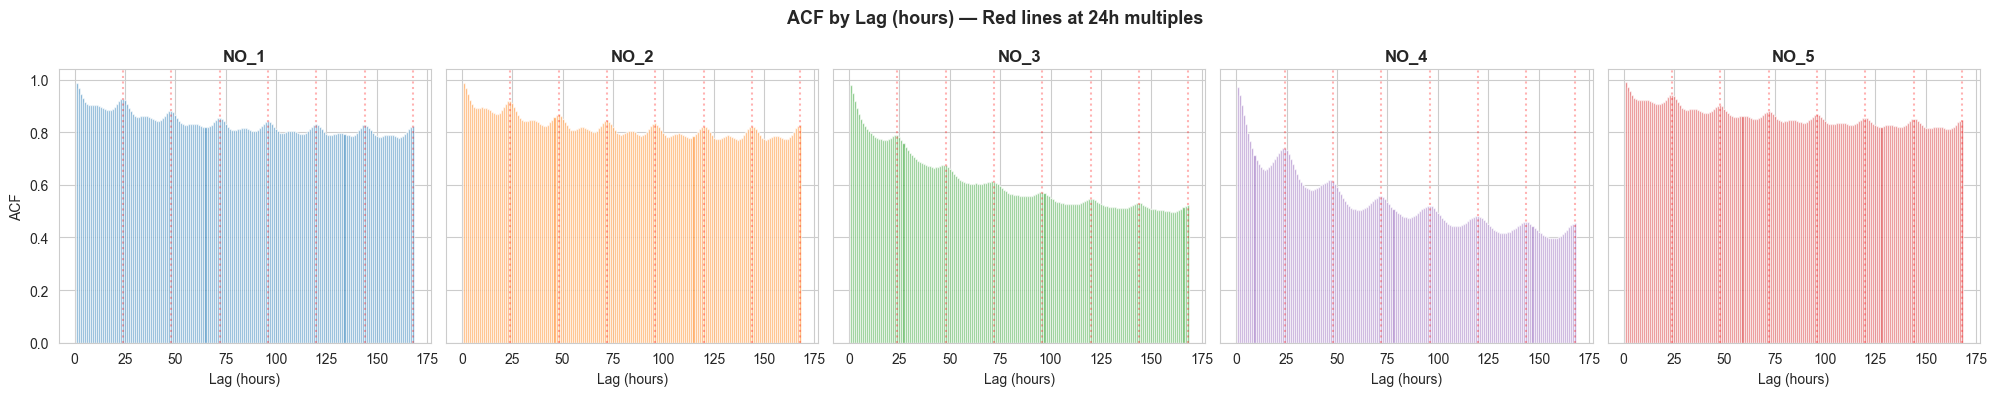

In [28]:
# ── 7c: Dominant lag identification ──────────────────────────────────

print("TOP 10 ACF LAGS (hours) per zone:")
print("=" * 60)

fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

for i, z in enumerate(ZONES):
    s = prices_tz_naive[z].dropna()
    acf_vals = acf(s, nlags=168, fft=True)

    # Skip lag 0 (always 1.0)
    lag_importance = pd.Series(acf_vals[1:], index=range(1, 169))
    top_lags = lag_importance.abs().nlargest(10)

    print(f"\n{z} ({ZONE_LABELS[z]}):")
    for lag, val in top_lags.items():
        print(f"  Lag {lag:>3}h (={lag/24:.1f}d): ACF = {lag_importance[lag]:>+.4f}")

    ax = axes[i]
    ax.bar(range(1, 169), acf_vals[1:], color=ZONE_COLORS[z], alpha=0.7, width=1)
    ax.set_title(z, fontweight="bold")
    ax.set_xlabel("Lag (hours)")
    if i == 0:
        ax.set_ylabel("ACF")
    # Mark key lags
    for lag_mark in [24, 48, 72, 96, 120, 144, 168]:
        ax.axvline(lag_mark, color="red", linestyle=":", alpha=0.3)

fig.suptitle("ACF by Lag (hours) — Red lines at 24h multiples", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

---
## 8. Key Findings Summary

In [29]:
# ── 8: Compile all findings ──────────────────────────────────────────

print("=" * 80)
print("STATISTICAL INFERENCE — KEY FINDINGS")
print(f"(Prices in EUR/MWh; NOK/kWh at avg EUR/NOK = {AVG_EUR_NOK:.2f})")
print("=" * 80)

print("\n1. PRICE DISTRIBUTIONS")
print("-" * 40)
print("- All zones reject normality (Shapiro-Wilk p < 0.05)")
print("- Prices are right-skewed with fat tails (leptokurtic)")
print("- Log-normal provides a better fit (QQ plots closer to diagonal)")
print("\u2192 Implication: Tree models preferred over linear; consider log-transform for linear models")

print("\n2. SEASONAL PATTERNS")
print("-" * 40)
print("- Weekly seasonality confirmed by STL decomposition")
for z, v in seasonal_strength.items():
    print(f"  {z}: weekly seasonal strength = {v:.3f}")
print("- Day-of-week effect is highly significant (Kruskal-Wallis p < 0.001)")
print("\u2192 Implication: Include hour_of_day, day_of_week, is_weekend as features")

print("\n3. RESERVOIR IMPACT")
print("-" * 40)
for z, rho in res_price_corr.items():
    print(f"  {z}: Spearman \u03c1 = {rho:+.4f} (filling vs price)")
print("- Granger causality: reservoir changes help predict price changes at multiple lags")
print("\u2192 Implication: reservoir_filling and filling_vs_median are strong features")

print("\n4. EXPORT/IMPORT PATTERNS")
print("-" * 40)
print(f"- Norway exports {pct_export:.0f}% of days")
print(f"- Export vs import day prices differ significantly (Mann-Whitney p < 0.05)")
print("\u2192 Implication: net_exchange and production_surplus are useful features")

print("\n5. COMMODITY PASSTHROUGH")
print("-" * 40)
for z, m in ols_results.items():
    print(f"  {z}: R\u00b2 = {m.rsquared:.3f} (price ~ commodities + FX)")
print("- Gas-electricity relationship shows structural break around energy crisis")
print("\u2192 Implication: TTF gas is #1 external predictor; relationship is time-varying")

print("\n6. ZONE DECOUPLING")
print("-" * 40)
print("- Zone pairs ranked by correlation (see Section 6a)")
print("- Price spreads tested for stationarity (see ADF results above)")
print(f"- North-South: south higher {pct_south_higher:.0f}% of days, mean spread = {ns_spread.mean():.2f} EUR/MWh ({ns_spread.mean()*AVG_EUR_NOK/1000:.3f} NOK/kWh)")
print("\u2192 Implication: Cross-zone spreads as features; separate models per zone recommended")

print("\n7. AUTOCORRELATION")
print("-" * 40)
print("- Strong autocorrelation at lags 1, 24, 48, 72, ..., 168 hours")
print("- 24h seasonal differencing improves stationarity")
print("- Weekly (168h) lag remains significant after daily differencing")
print("\u2192 Implication: price_lag_1h, price_lag_24h, price_lag_168h are essential features")

print("\n" + "=" * 80)
print("MODELING RECOMMENDATIONS FOR PHASE 3")
print("=" * 80)
print("""  
1. Use tree-based models (XGBoost/LightGBM/CatBoost) — prices are non-normal
2. Essential features: price lags (1h, 24h, 168h), calendar (hour, DOW, weekend),
   TTF gas, reservoir filling, temperature, net exchange
3. Train separate models per zone — zones decouple significantly
4. Naive baseline (same hour last week) is strong due to 168h autocorrelation
5. Consider regime-dependent models (crisis vs normal periods)
6. Walk-forward validation with expanding window
7. Use EUR/MWh for modeling (NOK features are ~r>0.99 correlated); NOK/kWh for reporting
""")

STATISTICAL INFERENCE — KEY FINDINGS
(Prices in EUR/MWh; NOK/kWh at avg EUR/NOK = 11.22)

1. PRICE DISTRIBUTIONS
----------------------------------------
- All zones reject normality (Shapiro-Wilk p < 0.05)
- Prices are right-skewed with fat tails (leptokurtic)
- Log-normal provides a better fit (QQ plots closer to diagonal)
→ Implication: Tree models preferred over linear; consider log-transform for linear models

2. SEASONAL PATTERNS
----------------------------------------
- Weekly seasonality confirmed by STL decomposition
  NO_1: weekly seasonal strength = 0.215
  NO_2: weekly seasonal strength = 0.305
  NO_3: weekly seasonal strength = 0.150
  NO_4: weekly seasonal strength = 0.197
  NO_5: weekly seasonal strength = 0.229
- Day-of-week effect is highly significant (Kruskal-Wallis p < 0.001)
→ Implication: Include hour_of_day, day_of_week, is_weekend as features

3. RESERVOIR IMPACT
----------------------------------------
  NO_1: Spearman ρ = -0.5072 (filling vs price)
  NO_2: Sp